In [70]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import dataframe_image as dfi
from string import Template
from os import listdir
from os.path import isfile, join

# Some Constants + Helper Function

In [71]:
cost_of_electricity_per_Kwh = 0.2
period = 1/6

# Sources
# US https://www.eia.gov/tools/faqs/faq.php?id=74&t=11 # <- converted from pounds to grams
# Ireland https://www.eea.europa.eu/data-and-maps/daviz/co2-emission-intensity-6#tab-googlechartid_googlechartid_chart_111_filters=%7B%22rowFilters%22%3A%7B%7D%3B%22columnFilters%22%3A%7B%22pre_config_date%22%3A%5B2019%5D%7D%3B%22sortFilter%22%3A%5B%22ugeo%22%5D%7D
# https://www.eea.europa.eu/data-and-maps/daviz/co2-emission-intensity-6#tab-googlechartid_googlechartid_googlechartid_googlechartid_chart_11111

carbon_intensities = {
    'Ireland':316,
    'EU' : 275,
    'US' : 417
}

colours = ['#0072B2', '#009E73', '#F0E442']

categories = ['News', 'Retail', 'Social_Media', 'Video_Streaming', 'Baselines']
browsers = ['Edge', 'Firefox', 'Vivaldi']

def template_path(category, browser):
    if browser not in browsers:
        raise ValueError(f'Invalid browser passed, {browser}, valid browsers {browsers}')
        
    return f'papillon_results/{category}/{browser}'

def build_file_path(category, browser, filename):
    return f'{template_path(category, browser)}/{filename}'

def watthours_to_watts(wh):
    return wh/period

def watts_to_watthours(watts, period):
    return watts * period

def convert_wh_to_cost(wh):
    return round((wh/1000) * cost_of_electricity_per_Kwh, 5)

# Carbon intensity is the measure of C02 released per Kwh, measured in grams
def kwh_to_grams_carbon(kwh, carbon_intensity):
    return round(kwh * carbon_intensity,6)

## Used for extracting the data taken from Papillon for websites.
## Loads the JSON data for each file, then for each entry in the file, extracts the necessary metrics
## Stat1 is CPU Utilization
## Stat2 is Network bytesin +  bytesout
## Stat3 is Memory pageins + pageouts
## Returns a pandas dataframe containing the information relating to a single website, which was taken using a particular browser
def extract_info(data, category, browser):
    webpages = {}

    for file in data:
        with open(file, 'r') as f:
            data = json.load(f)
            webpage_name  = file[len(f'papillon_results/{browser}/' + category + '/'):]
            webpage_name = webpage_name[:-5]
            print(f'\t\t{webpage_name}')

            rows = []
            for i in range(len(data['activity'])):
                data_dict = data['activity'][i]
                apps = data_dict['apps']['app']
                app_total=0
                
                for e in apps:
                    if re.search(rf"(?i)(C1|E1|F1|V1|{browser})", e['name'], re.IGNORECASE) :
                        app_total += float(e['cpu'])
                
                rows.append({
                    'Watts' : round(float(data_dict['power']), 8),
                    'Whrs' : round(float(data_dict['power']) * period, 8),
                    'Timestamp' : float(data_dict['timeStamp']),
                    'Stat1' : round(float(data_dict['stat1']), 8),
                    'Stat2' : round(float(data_dict['stat2']), 8),
                    'Stat3' : round(float(data_dict['stat3']), 8),
                    'All Apps' : data_dict['allApps'],
                    'Tagged App' : app_total
                })
            df = pd.DataFrame(rows)
            if webpage_name not in webpages:
                webpages[webpage_name] = df
            else:
                webpages[webpage_name] = webpages[webpage_name].append(df, ignore_index=True)
                
    return webpages

## Simple data class to store some information more easily
class CategoryData:
    
    def __init__(self, browser, data):
        self.browser = browser
        self.data = data

In [72]:
assert 'papillon_results/News/Edge' == template_path('News', 'Edge')
assert 'papillon_results/Baselines/Edge' == template_path('Baselines', 'Edge')

assert 'papillon_results/News/Edge/Independent.json' == build_file_path('News', 'Edge', 'Independent.json')
assert 'papillon_results/Baselines/Edge/Edge1.json' == build_file_path('Baselines', 'Edge', 'Edge1.json')

# Baselines
The following cells relate to extracting the data taken for the browsers. The functionality is similar to the extract_info method in the helper functions cell, but different since it doesn't have the addtional layer(categories/websites) of information.

In [73]:
browser_frames = {}

for browser in browsers:
    print(f'Browser = {browser}')
    for file in os.listdir(template_path('Baselines', browser)):
        file_path = build_file_path('Baselines', browser, file)
        print(file_path)
        with open(file_path, 'r+') as baseline_file:
            data = json.load(baseline_file)
            rows = []
            for i in range(len(data['activity'])):
                data_dict = data['activity'][i]
                apps = data_dict['apps']['app']
                app_total=0
                for e in apps:
                    if re.search(rf"(?i)(C1|E1|F1|V1|{browser})", e['name'], re.IGNORECASE) :
                        app_total += float(e['cpu'])
                rows.append({
                    'Watts' : round(float(data_dict['power']), 8),
                    'Whrs' : round(float(data_dict['power'])/60, 8),
                    'Timestamp' : float(data_dict['timeStamp']),
                    'Stat1' : round(float(data_dict['stat1']), 8),
                    'Stat2' : round(float(data_dict['stat2']), 8),
                    'Stat3' : round(float(data_dict['stat3']), 8),
                    'All Apps' : data_dict['allApps'],
                    'Tagged App' : app_total
                })
            df = pd.DataFrame(rows)
            if browser not in browser_frames:
                browser_frames[browser] = df
            else:
                browser_frames[browser] = browser_frames[browser].append(df, ignore_index=True)

Browser = Edge
papillon_results/Baselines/Edge/Edge1.json
papillon_results/Baselines/Edge/Edge2.json
Browser = Firefox
papillon_results/Baselines/Firefox/Firefox1.json
papillon_results/Baselines/Firefox/Firefox2.json
Browser = Vivaldi
papillon_results/Baselines/Vivaldi/Vivaldi1.json
papillon_results/Baselines/Vivaldi/Vivaldi2.json


In [74]:
for b in browser_frames:
    print(b)
    display(browser_frames[b])

Edge


,Watts,Whrs,Timestamp,Stat1,Stat2,Stat3,All Apps,Tagged App
0,6.351884,0.105865,1.616871e+09,4.691931,9589418.0,11722752.0,1430.0,900.0
1,8.055542,0.134259,1.616871e+09,2.636212,1150366.0,20422656.0,520.0,320.0
2,2.175933,0.036266,1.616871e+09,0.564325,24980.0,585728.0,320.0,100.0
3,2.083333,0.034722,1.616871e+09,0.546482,25364.0,516096.0,300.0,110.0
4,2.083333,0.034722,1.616871e+09,0.632098,23556.0,606208.0,360.0,150.0
5,2.175933,0.036266,1.616871e+09,0.687317,24044.0,786432.0,310.0,140.0
6,2.083333,0.034722,1.616871e+09,0.562589,22986.0,782336.0,320.0,140.0
7,2.175933,0.036266,1.616871e+09,0.685537,25962.0,798720.0,350.0,140.0
8,2.175933,0.036266,1.616872e+09,0.446010,23754.0,540672.0,350.0,140.0
9,2.175933,0.036266,1.616872e+09,0.614824,24166.0,675840.0,370.0,150.0


Firefox


,Watts,Whrs,Timestamp,Stat1,Stat2,Stat3,All Apps,Tagged App
0,2.175933,0.036266,1.616870e+09,2.772194,34440.0,1064960.0,600.0,310.0
1,2.175933,0.036266,1.616870e+09,0.627427,23720.0,610304.0,680.0,240.0
2,2.175933,0.036266,1.616870e+09,0.465903,23696.0,544768.0,430.0,150.0
3,2.175933,0.036266,1.616870e+09,0.562610,25081.0,610304.0,360.0,160.0
4,2.083333,0.034722,1.616870e+09,0.513108,24906.0,786432.0,420.0,160.0
5,2.250000,0.037500,1.616871e+09,0.704395,37179.0,1314816.0,460.0,260.0
6,5.851851,0.097531,1.616871e+09,9.877723,806223.0,11100160.0,1150.0,220.0
7,2.083333,0.034722,1.616871e+09,0.582324,24224.0,802816.0,410.0,160.0
8,2.083333,0.034722,1.616871e+09,0.528396,25835.0,512000.0,420.0,170.0
9,2.083333,0.034722,1.616871e+09,0.377347,23466.0,544768.0,350.0,150.0


Vivaldi


,Watts,Whrs,Timestamp,Stat1,Stat2,Stat3,All Apps,Tagged App
0,8.672830,0.144547,1.617545e+09,5.974579,59244.0,43597824.0,2280.0,0.0
1,2.083333,0.034722,1.617545e+09,0.630917,25920.0,516096.0,270.0,20.0
2,6.287052,0.104784,1.617545e+09,1.419347,38901.0,14860288.0,530.0,250.0
3,2.083333,0.034722,1.617545e+09,0.714687,25930.0,1003520.0,760.0,250.0
4,2.175933,0.036266,1.617545e+09,1.149353,24869.0,573440.0,820.0,550.0
5,2.083333,0.034722,1.617545e+09,1.252078,25400.0,503808.0,780.0,550.0
6,2.175933,0.036266,1.617545e+09,1.228502,25339.0,528384.0,790.0,570.0
7,2.083333,0.034722,1.617545e+09,1.099575,25984.0,516096.0,770.0,550.0
8,10.833330,0.180556,1.617545e+09,11.154569,427786.0,364552192.0,930.0,630.0
9,2.175933,0.036266,1.617545e+09,0.535826,25308.0,655360.0,830.0,550.0


## Mean Power Per Minute

In [75]:
mean_power_values = [round(browser_frames[browser]['Watts'].mean(), 6) for browser in browsers]
print(mean_power_values)

[3.072027, 3.294556, 3.097534]


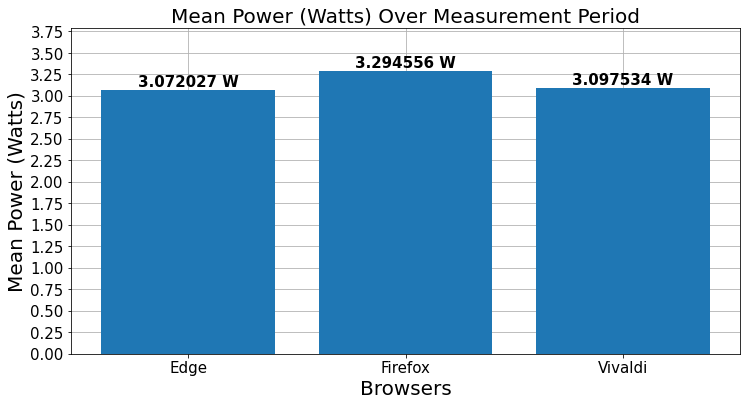

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Mean Power (Watts) Over Measurement Period', fontsize=20)
plt.ylabel('Mean Power (Watts)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(mean_power_values)+0.5, 0.25)], fontsize=15)
plt.ylim(0, max(mean_power_values)+0.5)
plt.xlabel('Browsers', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(browsers, mean_power_values, align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%f W' % height, fontsize=15, ha='center', va='bottom',weight='bold')

plt.savefig('plots/papillon/mean_power_per_minute.jpg')
plt.show()

## Cost Over Time

To convert to cost, the mean power(W)/minute is first converted to WattHours, this is done by multiplying it by the measurement period which is 10 minutes out of 60 minutes in an hour or 1/6.

(Watts/6) * 0.2 = cost

In [77]:
cost_values = [convert_wh_to_cost(watts_to_watthours(mean_value, period)) for mean_value in mean_power_values]
print(cost_values)
rows = []
for i in range(len(browsers)):
    browser_name = browsers[i]
    cost_per_ten_minutes = cost_values[i]
    cost_per_minute = cost_per_ten_minutes / 10
    cost_per_hour = cost_per_ten_minutes * 6
    cost_per_day = cost_per_hour * 24 
    rows.append({
        'Browser' : browser_name,
        'Cost Per Minute' : cost_per_minute,
        'Cost Per 10 Minutes' : cost_per_ten_minutes,
        'Cost Per Hour' : cost_per_hour,
        'Cost Per Day' : cost_per_day
    })
cost_df = pd.DataFrame(rows)

[0.0001, 0.00011, 0.0001]


In [78]:
display(cost_df.style.set_caption('Cost of Running an Idle Browser in Euro Cent'))
dfi.export(cost_df.style.set_caption('Cost of Running an Idle Browser in Euro Cent'),"plots/papillon/cost_table.jpg")

,Browser,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,Edge,0.000010,0.000100,0.000600,0.014400
1,Firefox,0.000011,0.000110,0.000660,0.015840
2,Vivaldi,0.000010,0.000100,0.000600,0.014400


In [79]:
watthours_per_browser = [watts * period for watts in mean_power_values]
watthours_per = [watts * 10 for watts in mean_power_values]
print(watthours_per_browser)
print(watthours_per)

[0.5120045, 0.5490926666666667, 0.5162556666666667]
[30.72027, 32.94556, 30.97534]


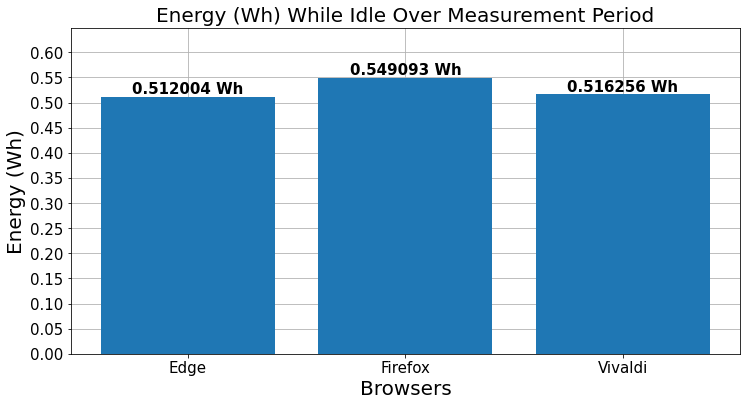

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Energy (Wh) While Idle Over Measurement Period', fontsize=20)
plt.ylabel('Energy (Wh)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(watthours_per_browser)+ 0.6,0.05)], fontsize=15)
plt.ylim(0, max(watthours_per_browser) + 0.1)
plt.xlabel('Browsers', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(browsers, watthours_per_browser, align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%f Wh' % height, fontsize=15, ha='center', va='bottom',weight='bold')

plt.savefig('plots/papillon/energy_consumption.jpg')
plt.show()

In [81]:
## Convert energy to carbon for each carbon intensity value
grams_per_region = {}
for ci in carbon_intensities:
    ci_value = carbon_intensities[ci]
    grams = [kwh_to_grams_carbon(value/1000, ci_value) for value in watthours_per_browser]
    grams_per_region[ci] = grams
print(grams_per_region)

{'Ireland': [0.161793, 0.173513, 0.163137], 'EU': [0.140801, 0.151, 0.14197], 'US': [0.213506, 0.228972, 0.215279]}


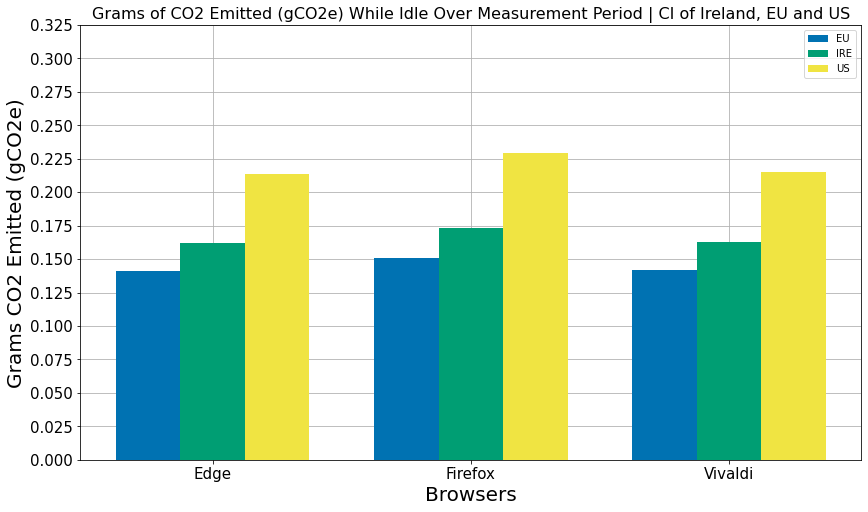

In [83]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.grid(zorder=0)
x = np.arange(len(browsers))  # the label locations
width = 0.25  # the width of the bars
rects2 = ax.bar(x , grams_per_region['EU'], width, label='EU', color=colours[0], zorder=3)
rects1 = ax.bar(x + width, grams_per_region['Ireland'], width, label='IRE', color=colours[1], zorder=3)
rects3 = ax.bar(x + width*2, grams_per_region['US'], width, label='US', color=colours[2] , zorder=3)

plt.title('Grams of CO2 Emitted (gCO2e) While Idle Over Measurement Period | CI of Ireland, EU and US', fontsize=16)
plt.xticks(x+width, browsers, fontsize=15)
max_y = max(max([grams_per_region[region] for region in grams_per_region]))
plt.yticks([i for i in np.arange(0, max_y + 0.1, 0.025)], fontsize=15)
ax.set_xticklabels(browsers)
ax.legend()

plt.ylabel('Grams CO2 Emitted (gCO2e)',fontsize=20)
plt.xlabel('Browsers', fontsize=20)

# fig.tight_layout()
plt.savefig('plots/papillon/browser_grams_emitted.jpg')
plt.show()

## Time for Some Assumptions

There is approximately 4.8 billions daily internet users (source in report), of those, we'll assume that 1/5 of them leave their browser idle for 10 minutes in the day

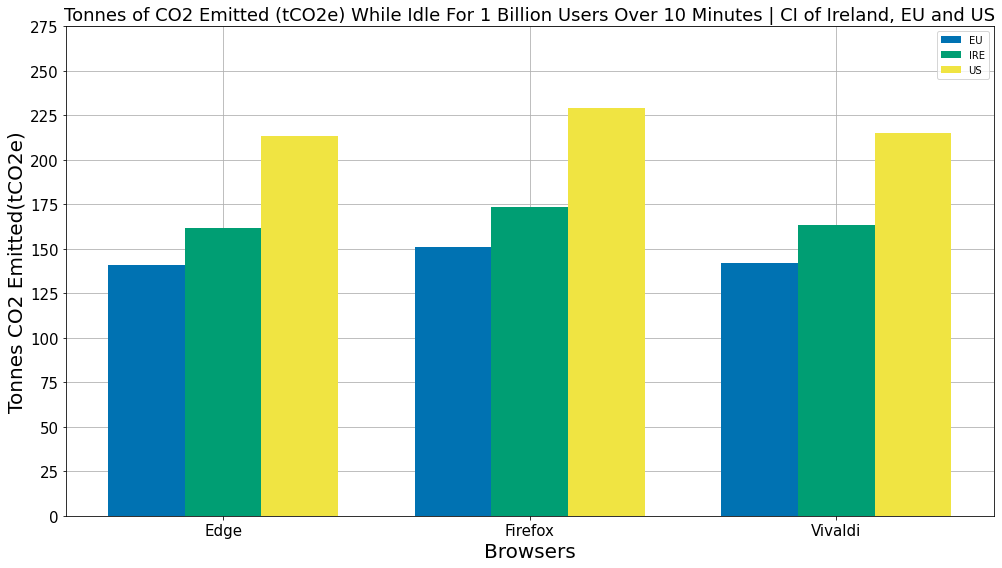

In [85]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.grid(zorder=0)
x = np.arange(len(browsers))  # the label locations
width = 0.25  # the width of the bars

y_values = {}
for region in grams_per_region:
    y_values[region] = [((grams_per_region[region][i] * 1e+9) /1000) /1000 for i in range(len(grams_per_region[region])) ]
rects2 = ax.bar(x , y_values['EU'], width, label='EU', color=colours[0], zorder=3)
rects1 = ax.bar(x + width, y_values['Ireland'], width, label='IRE', color=colours[1], zorder=3)
rects3 = ax.bar(x + width*2, y_values['US'], width, label='US', color=colours[2] , zorder=3)

plt.title('Tonnes of CO2 Emitted (tCO2e) While Idle For 1 Billion Users Over 10 Minutes | CI of Ireland, EU and US', fontsize=18)
plt.xticks(x+width, browsers, fontsize=15)


max_y = max(max([y_values[region] for region in y_values]))
plt.yticks([i for i in np.arange(0, max_y+50, 25)], fontsize=15)

# plt.ylim(0, 2e+9)
ax.set_xticklabels(browsers)
ax.legend()

plt.ylabel('Tonnes CO2 Emitted(tCO2e)',fontsize=20)
plt.xlabel('Browsers', fontsize=20)

fig.tight_layout()
plt.savefig('plots/papillon/browser_grams_emitted_billion.jpg')
plt.show()

# Websites 

In [86]:
files = [build_file_path('Custom', 'Firefox', file) for file in os.listdir(template_path('Custom', 'Firefox'))]
category_info = CategoryData(browser, extract_info(files, 'Custom', 'Firefox'))

mean_power_value = category_info.data['2kmtcentral']['Watts'].mean()
print(mean_power_value)
carbon = kwh_to_grams_carbon(mean_power_value/1000, carbon_intensities['Ireland'])
print(f'gCO2e = {carbon} ')

		2kmtcentral
8.372055893636364
gCO2e = 2.64557 


In [87]:
category_data = {}
for category in categories[:-1]:
    for browser in browsers:
        print(f'{category}\n\t{browser}')
        files = [build_file_path(category, browser, file) for file in os.listdir(template_path(category, browser))]
        if category not in category_data:
            category_data[category] = []
        category_data[category].append(CategoryData(browser, extract_info(files, category, browser)))

News
	Edge
		GoogleNews
		Independent
		IrishTimes
		TheJournal
News
	Firefox
		GoogleNews
		Independent
		IrishTimes
		TheJournal
News
	Vivaldi
		GoogleNews
		Independent
		IrishTimes
		TheJournal
Retail
	Edge
		Amazon
		Asos
		Etsy
		Ikea
Retail
	Firefox
		Amazon
		Asos
		Etsy
		Ikea
Retail
	Vivaldi
		Amazon
		Asos
		Etsy
		Ikea
Social_Media
	Edge
		Facebook
		Instagram
		Reddit
		Twitter
Social_Media
	Firefox
		Facebook
		Instagram
		Reddit
		Twitter
Social_Media
	Vivaldi
		Facebook
		Instagram
		Reddit
		Twitter
Video_Streaming
	Edge
		DisneyPlus
		Netflix
		Twitch
		Youtube
Video_Streaming
	Firefox
		DisneyPlus
		Netflix
		Twitch
		Youtube
Video_Streaming
	Vivaldi
		DisneyPlus
		Netflix
		Twitch
		Youtube


In [88]:
per_browser_data = {}
for category in categories[:-1]:
    if category not in per_browser_data:
        per_browser_data[category] = {}
    for i in range(len(browsers)):
        data = category_data[category][i].data
        mean_power_values = []
        for website in data:
            mean_power_values.append((website, round(data[website]['Watts'].mean(), 5)))
#             summed_page_power.append((website, round(data[website]['Power/60'].sum(), 5)))
        per_browser_data[category][browsers[i]] = mean_power_values

for c in per_browser_data:
    print(c)
    for b in per_browser_data[c]:
        print(f'Category: {c}, Browser: {b}')
        print(per_browser_data[c][b])
        print()
    print()

News
Category: News, Browser: Edge
[('GoogleNews', 5.70371), ('Independent', 5.32524), ('IrishTimes', 4.6518), ('TheJournal', 4.28518)]

Category: News, Browser: Firefox
[('GoogleNews', 5.89194), ('Independent', 5.37024), ('IrishTimes', 6.12562), ('TheJournal', 3.98308)]

Category: News, Browser: Vivaldi
[('GoogleNews', 5.44468), ('Independent', 3.96045), ('IrishTimes', 4.76482), ('TheJournal', 3.13131)]


Retail
Category: Retail, Browser: Edge
[('Amazon', 8.00371), ('Asos', 6.7352), ('Etsy', 5.38026), ('Ikea', 6.07235)]

Category: Retail, Browser: Firefox
[('Amazon', 7.11054), ('Asos', 7.04328), ('Etsy', 6.19298), ('Ikea', 7.44123)]

Category: Retail, Browser: Vivaldi
[('Amazon', 6.54277), ('Asos', 4.89687), ('Etsy', 5.70026), ('Ikea', 6.96718)]


Social_Media
Category: Social_Media, Browser: Edge
[('Facebook', 7.74115), ('Instagram', 7.11034), ('Reddit', 7.4682), ('Twitter', 4.64753)]

Category: Social_Media, Browser: Firefox
[('Facebook', 7.49892), ('Instagram', 8.44921), ('Reddit',

['GoogleNews', 'Independent', 'IrishTimes', 'TheJournal']
Max_Y = 6.12562


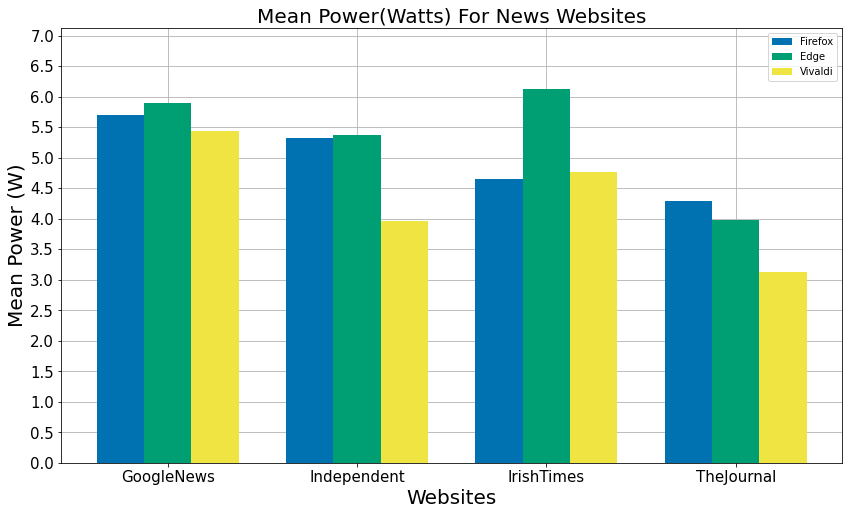

['Amazon', 'Asos', 'Etsy', 'Ikea']
Max_Y = 8.00371


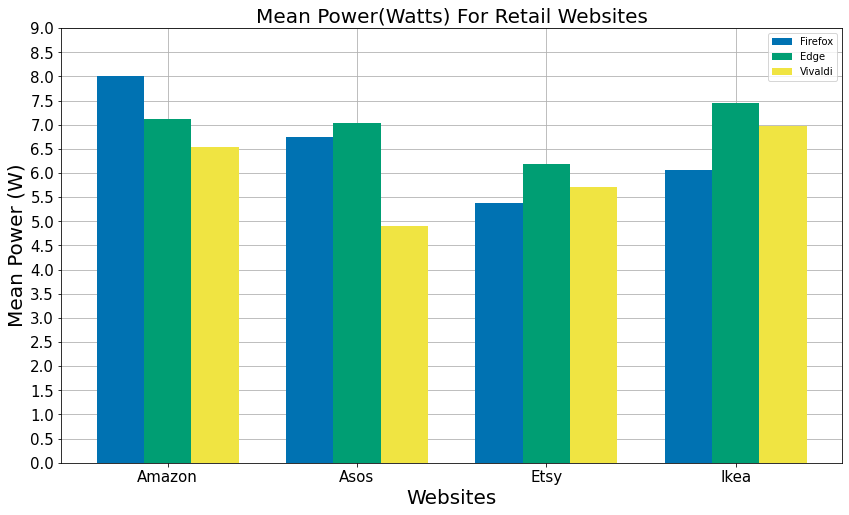

['Facebook', 'Instagram', 'Reddit', 'Twitter']
Max_Y = 9.43866


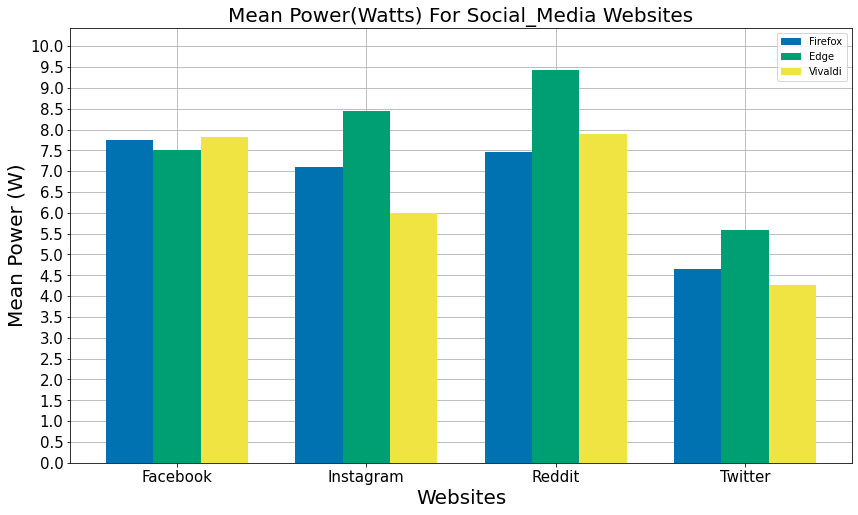

['DisneyPlus', 'Netflix', 'Twitch', 'Youtube']
Max_Y = 10.4213


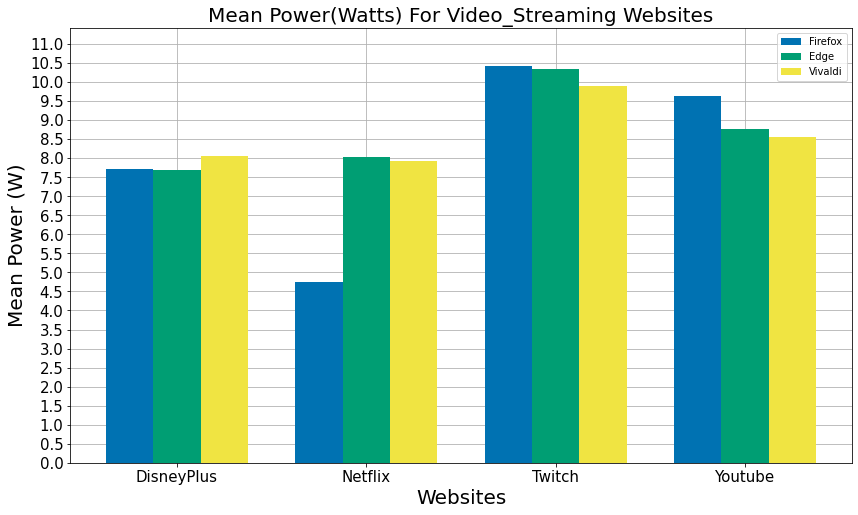

In [89]:
for category in categories[:-1]:
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.grid(zorder=0)
    data_dict = per_browser_data[category]
#     x_labels = set([t[0] for t in data_dict[browser] for browser in browsers]) ## dirty but easy
    x_labels = []
    for browser in browsers:
        for l in data_dict[browser]:
            if l[0] not in x_labels:
                x_labels.append(l[0])
    print(x_labels)
    x = np.arange(len(x_labels))  # the label locations
    width = 0.25  # the width of the bars
    bar_locations = [x, x+width, x+width*2]
    y_data = []

    for i in range(len(browsers)):
        y_data.append([t[1] for t in data_dict[browsers[i]]])

    plt.xticks(x+width, x_labels, fontsize=15)
    ax.set_xticklabels(x_labels)

    max_y = max([max(y) for y in y_data])
    print(f'Max_Y = {max_y}')
    plt.yticks([y for y in np.arange(0, max_y+3, 0.5)],fontsize=15)
    plt.ylim(0, max_y+1)
    bar_one = ax.bar(bar_locations[0], y_data[0], width, label='Firefox', color=colours[0], zorder=3) # firefox
    bar_two = ax.bar(bar_locations[1], y_data[1], width, label='Edge', color=colours[1], zorder=3) # edge
    bar_three = ax.bar(bar_locations[2], y_data[2], width, label='Vivaldi', color=colours[2], zorder=3) # vivaldi
#     fig.tight_layout()
    ax.legend()
    
    plt.title(f'Mean Power(Watts) For {category} Websites', fontsize=20)
    plt.ylabel('Mean Power (W)', fontsize=20)
    plt.xlabel('Websites', fontsize=20)
    plt.savefig(f'plots/papillon/website_power_consumption_{category}.jpg')
    plt.show()

['GoogleNews', 'Independent', 'IrishTimes', 'TheJournal']
Max_Y = 1.0209366666666666


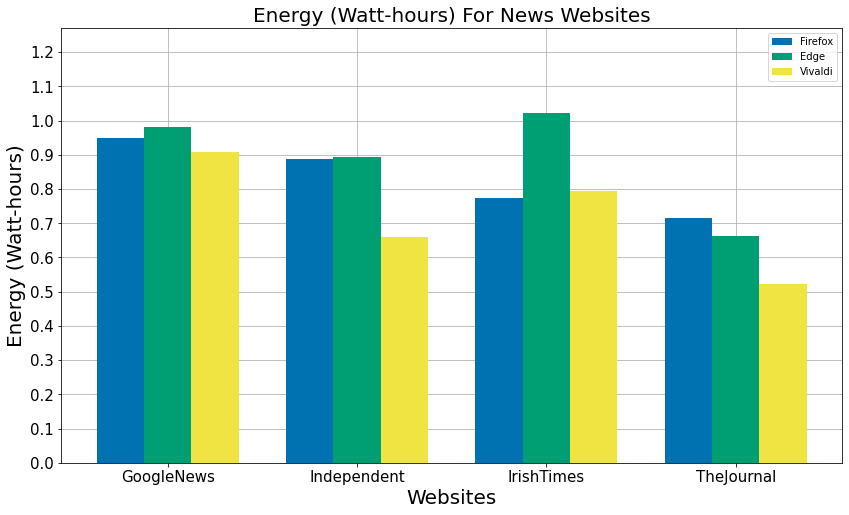

['Amazon', 'Asos', 'Etsy', 'Ikea']
Max_Y = 1.3339516666666666


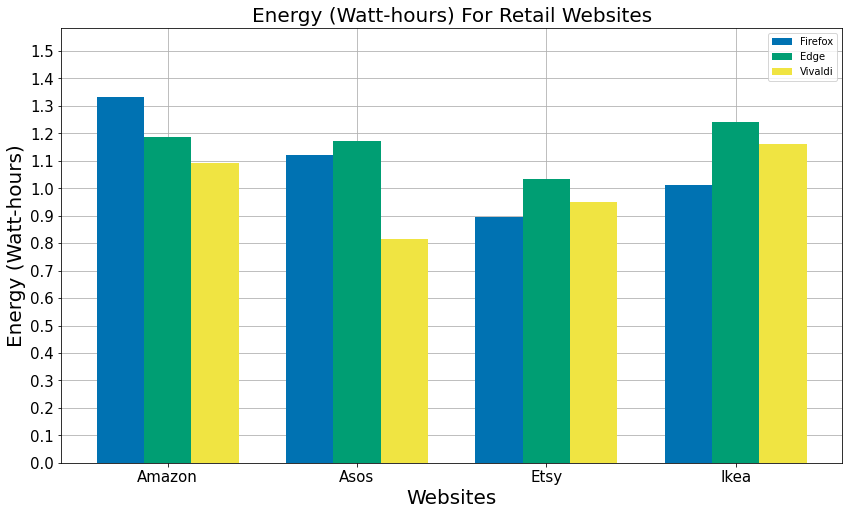

['Facebook', 'Instagram', 'Reddit', 'Twitter']
Max_Y = 1.57311


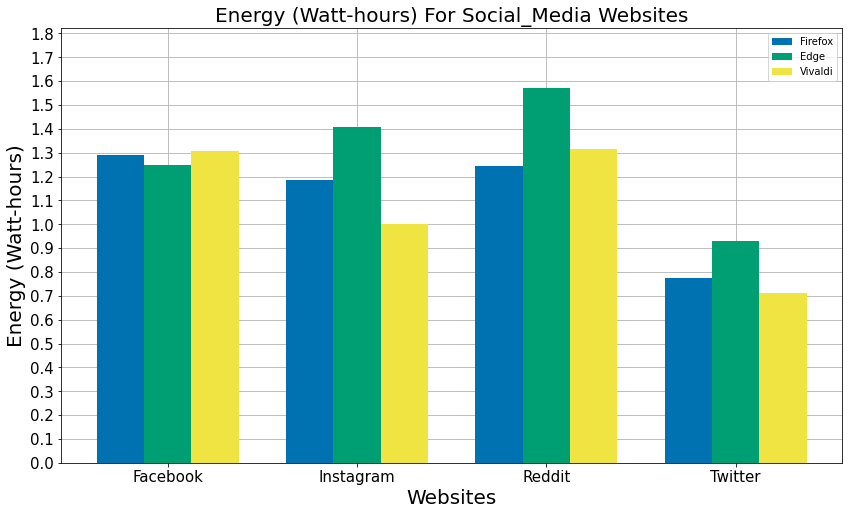

['DisneyPlus', 'Netflix', 'Twitch', 'Youtube']
Max_Y = 1.7368833333333333


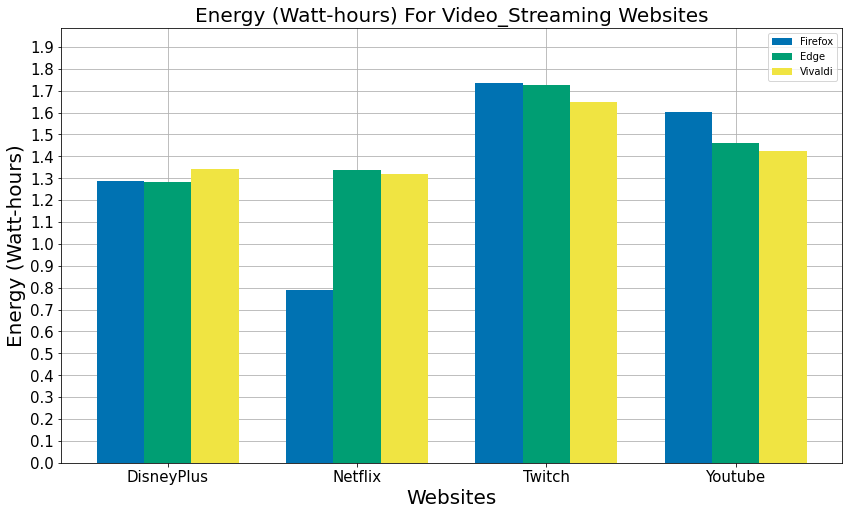

In [90]:
for category in categories[:-1]:
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.grid(zorder=0)
    data_dict = per_browser_data[category]
#     x_labels = set([t[0] for t in data_dict[browser] for browser in browsers]) ## dirty but easy
    x_labels = []
    for browser in browsers:
        for l in data_dict[browser]:
            if l[0] not in x_labels:
                x_labels.append(l[0])
    print(x_labels)
    x = np.arange(len(x_labels))  # the label locations
    width = 0.25  # the width of the bars
    bar_locations = [x, x+width, x+width*2]
    y_data = []

    for i in range(len(browsers)):
        y_data.append([t[1] * period for t in data_dict[browsers[i]]])

    plt.xticks(x+width, x_labels, fontsize=15)
    ax.set_xticklabels(x_labels)

    max_y = max([max(y) for y in y_data])
    print(f'Max_Y = {max_y}')
    plt.yticks([y for y in np.arange(0, max_y+0.25, 0.1)],fontsize=15)
    plt.ylim(0, max_y+0.25)
    bar_one = ax.bar(bar_locations[0], y_data[0], width, label='Firefox', color=colours[0], zorder=3) # firefox
    bar_two = ax.bar(bar_locations[1], y_data[1], width, label='Edge', color=colours[1], zorder=3) # edge
    bar_three = ax.bar(bar_locations[2], y_data[2], width, label='Vivaldi', color=colours[2], zorder=3) # vivaldi
#     fig.tight_layout()
    ax.legend()
    
    plt.title(f'Energy (Watt-hours) For {category} Websites', fontsize=20)
    plt.ylabel('Energy (Watt-hours)', fontsize=20)
    plt.xlabel('Websites', fontsize=20)
    plt.savefig(f'plots/papillon/website_energy_consumption_{category}.jpg')
    plt.show()

In [91]:
mean_browser_data = {}
for category in categories[:-1]:
    if category not in mean_browser_data:
        mean_browser_data[category] = {}
    ## category -> mean of website power across 3 browsers
    for i in range(len(browsers)):
        data = category_data[category][i].data
        for website in data:
            if website not in mean_browser_data[category]:
                mean_browser_data[category][website] = 0
            mean_browser_data[category][website] += data[website]["Watts"].mean()
    print(f'{category} - {mean_browser_data[category]}\n')
    for website in mean_browser_data[category]:
        mean_browser_data[category][website] = round(mean_browser_data[category][website]/len(browsers),5)
    print(f'{category} - {mean_browser_data[category]}\n')

News - {'GoogleNews': 17.040328275, 'Independent': 14.655916301272727, 'IrishTimes': 15.542230753090909, 'TheJournal': 11.399573696636363}

News - {'GoogleNews': 5.68011, 'Independent': 4.88531, 'IrishTimes': 5.18074, 'TheJournal': 3.79986}

Retail - {'Amazon': 21.657016783272727, 'Asos': 18.675350675, 'Etsy': 17.273508525545456, 'Ikea': 20.480763527727273}

Retail - {'Amazon': 7.21901, 'Asos': 6.22512, 'Etsy': 5.75784, 'Ikea': 6.82692}

Social_Media - {'Facebook': 23.070750193000002, 'Instagram': 21.555841867, 'Reddit': 24.791121407727275, 'Twitter': 14.512107191999998}

Social_Media - {'Facebook': 7.69025, 'Instagram': 7.18528, 'Reddit': 8.26371, 'Twitter': 4.83737}

Video_Streaming - {'DisneyPlus': 23.458945521, 'Netflix': 20.71084030718182, 'Twitch': 30.6666675, 'Youtube': 26.942220747818183}

Video_Streaming - {'DisneyPlus': 7.81965, 'Netflix': 6.90361, 'Twitch': 10.22222, 'Youtube': 8.98074}



['GoogleNews', 'Independent', 'IrishTimes', 'TheJournal']
Max_Y = 5.68011


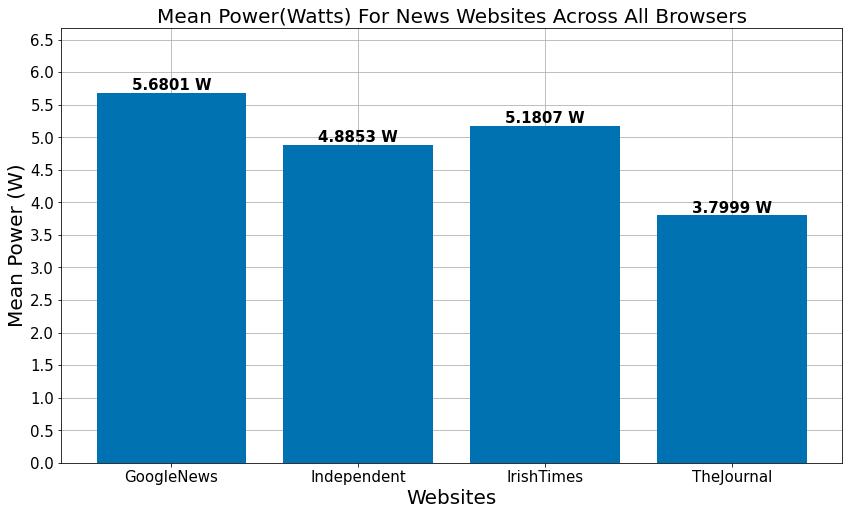

['Amazon', 'Asos', 'Etsy', 'Ikea']
Max_Y = 7.21901


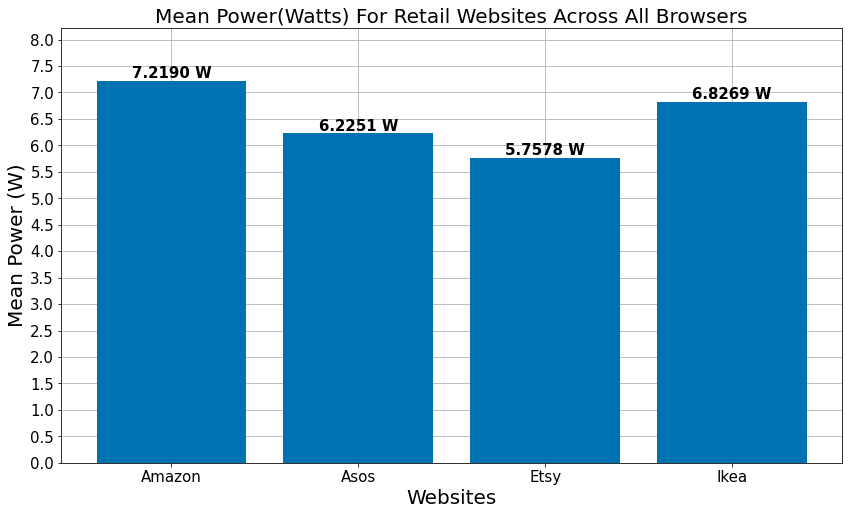

['Facebook', 'Instagram', 'Reddit', 'Twitter']
Max_Y = 8.26371


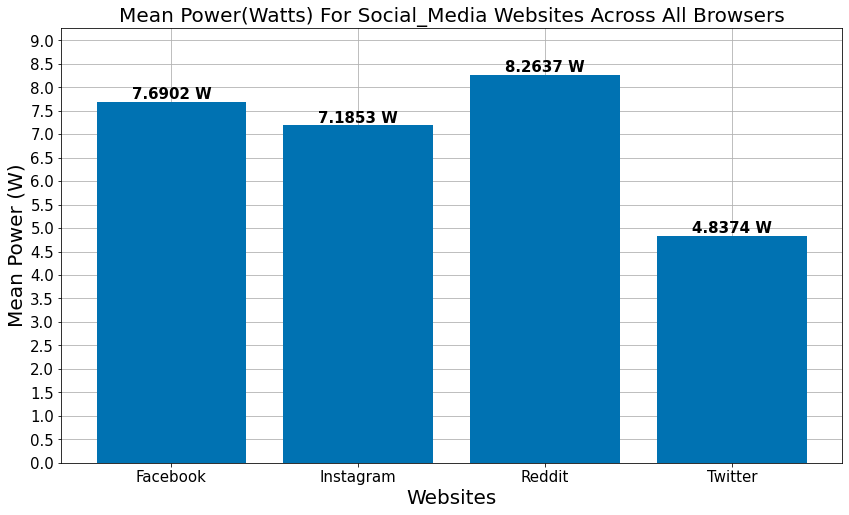

['DisneyPlus', 'Netflix', 'Twitch', 'Youtube']
Max_Y = 10.22222


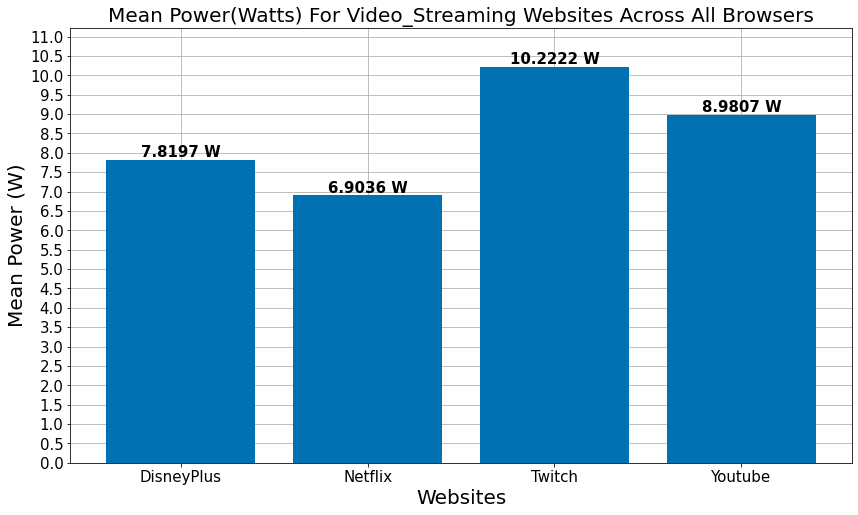

In [92]:
for category in categories[:-1]:
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.grid(zorder=0)
    data_dict = mean_browser_data[category]
#     x_labels = set([t[0] for t in data_dict[browser] for browser in browsers]) ## dirty but easy
    x_labels = [x for x in mean_browser_data[category]]
    print(x_labels)
    x = np.arange(len(x_labels))  # the label locations
    width = 0.25  # the width of the bars
    bar_locations = [x, x+width, x+width*2]
    y_data = []
#     print(data_dict[website])
    for website in x_labels:
        y_data.append(data_dict[website])

    plt.xticks(x+width, x_labels, fontsize=15)
    ax.set_xticklabels(x_labels)

    max_y = max(y_data)
    print(f'Max_Y = {max_y}')
    plt.yticks([y for y in np.arange(0, max_y+3, 0.5)],fontsize=15)
    plt.ylim(0, max_y+1)
    bars=ax.bar(bar_locations[1], y_data, color=colours[0], zorder=3) # firefox
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f W' % height,fontsize=15, ha='center', va='bottom',weight='bold')

#     fig.tight_layout()
#     ax.legend()
    
    plt.title(f'Mean Power(Watts) For {category} Websites Across All Browsers', fontsize=20)
    plt.ylabel('Mean Power (W)', fontsize=20)
    plt.xlabel('Websites', fontsize=20)
    plt.savefig(f'plots/papillon/website_power_consumption_{category}_all_browsers.jpg')
    plt.show()

['GoogleNews', 'Independent', 'IrishTimes', 'TheJournal']
Max_Y = 0.946685


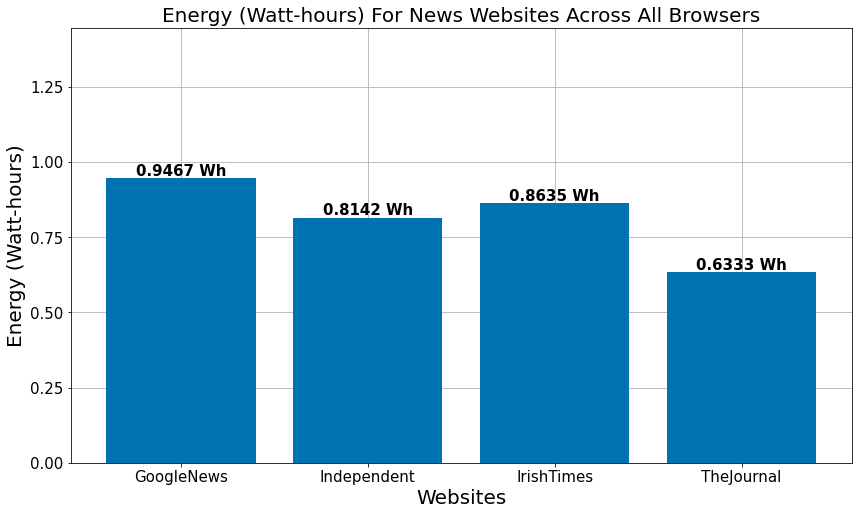

['Amazon', 'Asos', 'Etsy', 'Ikea']
Max_Y = 1.2031683333333332


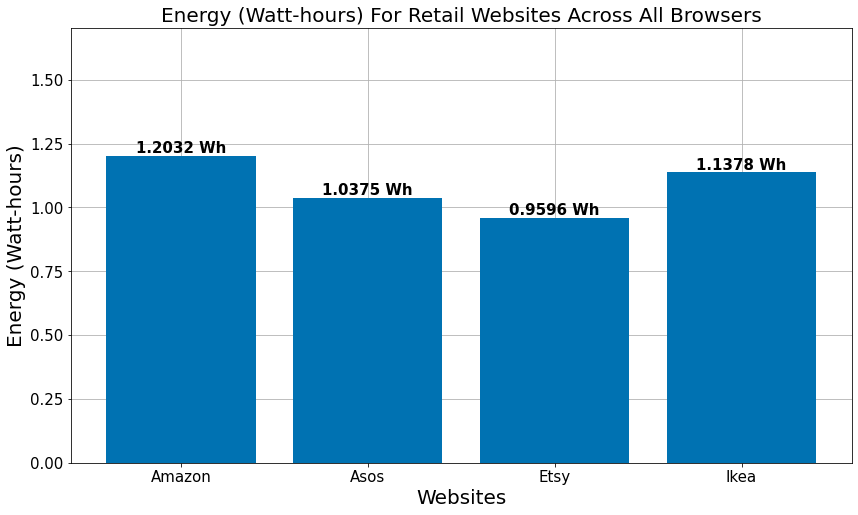

['Facebook', 'Instagram', 'Reddit', 'Twitter']
Max_Y = 1.3772849999999999


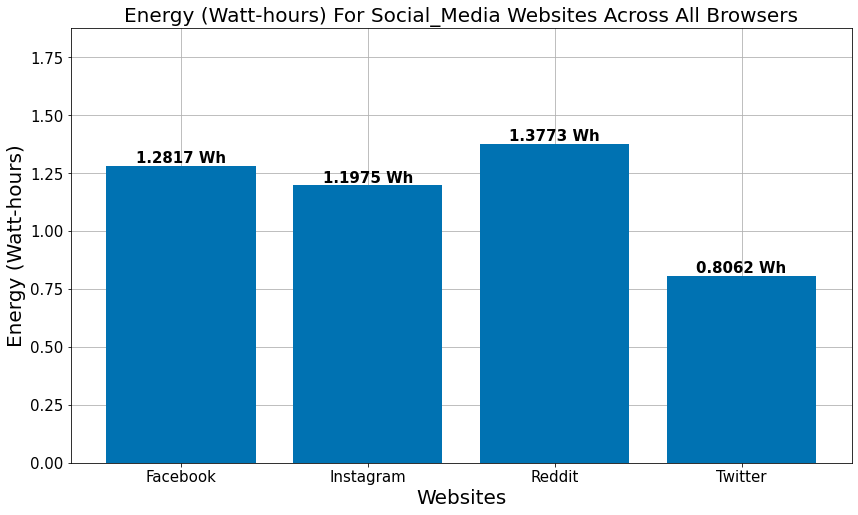

['DisneyPlus', 'Netflix', 'Twitch', 'Youtube']
Max_Y = 1.7037033333333333


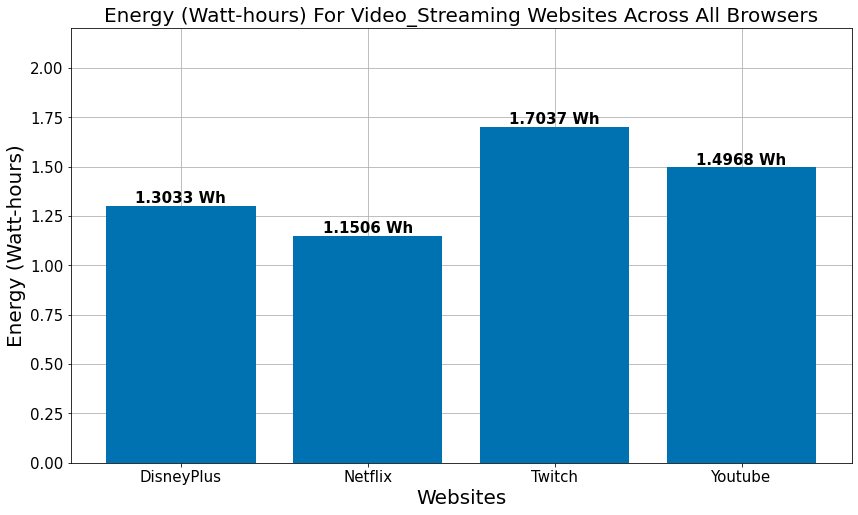

In [95]:
for category in categories[:-1]:
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.grid(zorder=0)
    data_dict = mean_browser_data[category]
#     x_labels = set([t[0] for t in data_dict[browser] for browser in browsers]) ## dirty but easy
    x_labels = [x for x in mean_browser_data[category]]
    print(x_labels)
    x = np.arange(len(x_labels))  # the label locations
    width = 0.25  # the width of the bars
    bar_locations = [x, x+width, x+width*2]
    y_data = []
#     print(data_dict[website])
    for website in x_labels:
        y_data.append(data_dict[website] * period)

    plt.xticks(x+width, x_labels, fontsize=15)
    ax.set_xticklabels(x_labels)

    max_y = max(y_data)
    print(f'Max_Y = {max_y}')
    plt.yticks([y for y in np.arange(0, max_y+1, 0.25)],fontsize=15)
    plt.ylim(0, max_y+0.5)
    bars=ax.bar(bar_locations[1], y_data, color=colours[0], zorder=3) # firefox
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f Wh' % height,fontsize=15, ha='center', va='bottom',weight='bold')
    
    plt.title(f'Energy (Watt-hours) For {category} Websites Across All Browsers', fontsize=20)
    plt.ylabel('Energy (Watt-hours)', fontsize=20)
    plt.xlabel('Websites', fontsize=20)
    plt.savefig(f'plots/papillon/website_energy_consumption_{category}_all_browsers.jpg')
    plt.show()

In [96]:
per_website_wh = {}
for category in categories[:-1]:
    if category not in per_website_wh:
        per_website_wh[category] = {}
    for i in range(len(browsers)):
        data = category_data[category][i].data
        mean_power_values = []
        for website in data:
            mean_power_values.append((website, round(data[website]['Watts'].mean()  * period, 5)))
#             summed_page_power.append((website, round(data[website]['Power/60'].sum(), 5)))
        per_website_wh[category][browsers[i]] = mean_power_values

for c in per_browser_data:
    print(c)
    for b in per_website_wh[c]:
        print(f'Category: {c}, Browser: {b}')
        print(per_website_wh[c][b])
        print()
    print()

News
Category: News, Browser: Edge
[('GoogleNews', 0.95062), ('Independent', 0.88754), ('IrishTimes', 0.7753), ('TheJournal', 0.7142)]

Category: News, Browser: Firefox
[('GoogleNews', 0.98199), ('Independent', 0.89504), ('IrishTimes', 1.02094), ('TheJournal', 0.66385)]

Category: News, Browser: Vivaldi
[('GoogleNews', 0.90745), ('Independent', 0.66007), ('IrishTimes', 0.79414), ('TheJournal', 0.52189)]


Retail
Category: Retail, Browser: Edge
[('Amazon', 1.33395), ('Asos', 1.12253), ('Etsy', 0.89671), ('Ikea', 1.01206)]

Category: Retail, Browser: Firefox
[('Amazon', 1.18509), ('Asos', 1.17388), ('Etsy', 1.03216), ('Ikea', 1.2402)]

Category: Retail, Browser: Vivaldi
[('Amazon', 1.09046), ('Asos', 0.81614), ('Etsy', 0.95004), ('Ikea', 1.1612)]


Social_Media
Category: Social_Media, Browser: Edge
[('Facebook', 1.29019), ('Instagram', 1.18506), ('Reddit', 1.2447), ('Twitter', 0.77459)]

Category: Social_Media, Browser: Firefox
[('Facebook', 1.24982), ('Instagram', 1.4082), ('Reddit', 1.

['GoogleNews', 'IrishTimes', 'Independent', 'TheJournal']
Max_Y = 0.322617


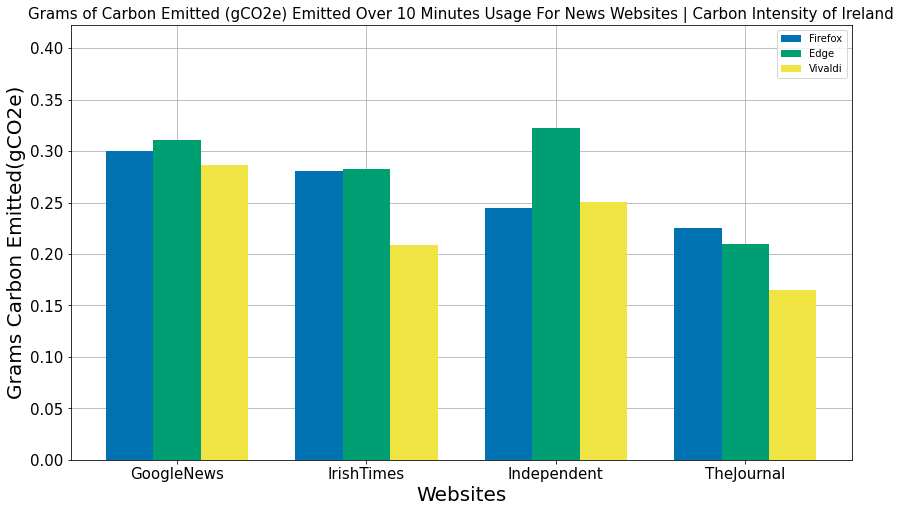

['Asos', 'Etsy', 'Amazon', 'Ikea']
Max_Y = 0.421528


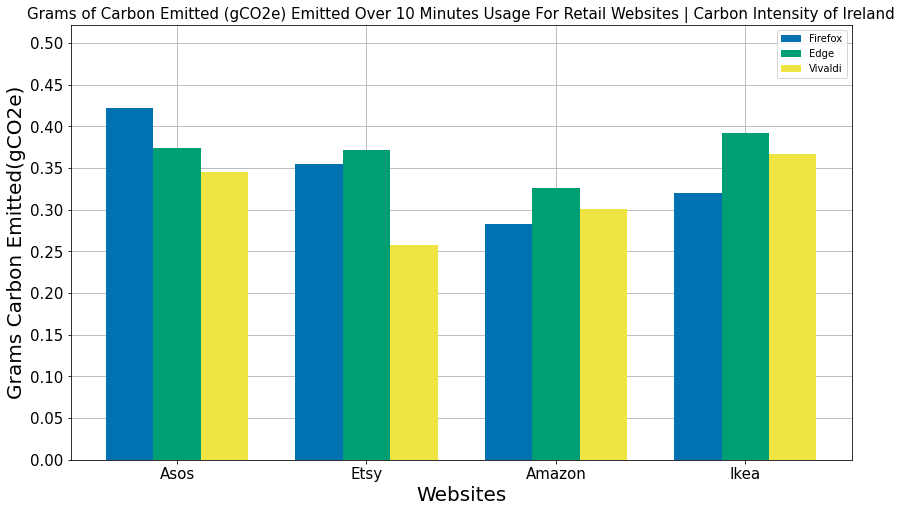

['Instagram', 'Twitter', 'Facebook', 'Reddit']
Max_Y = 0.497103


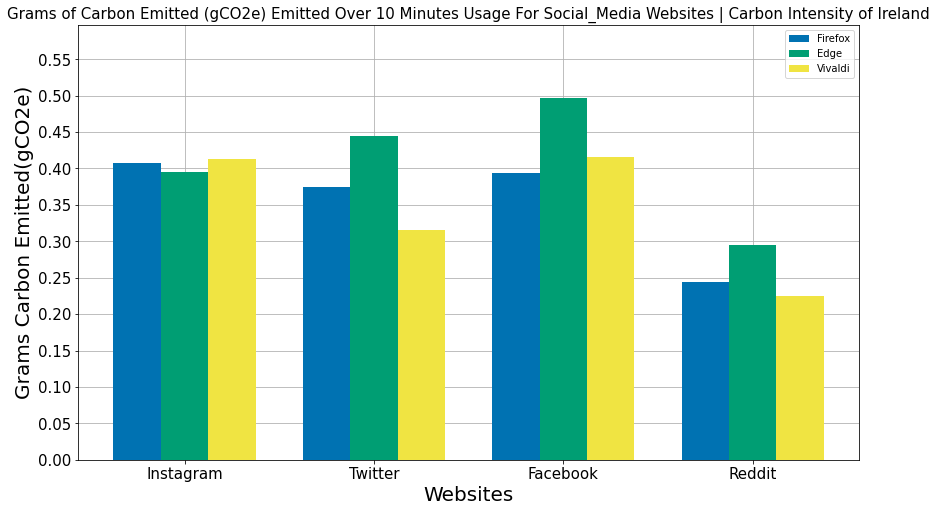

['Twitch', 'Youtube', 'Netflix', 'DisneyPlus']
Max_Y = 0.548854


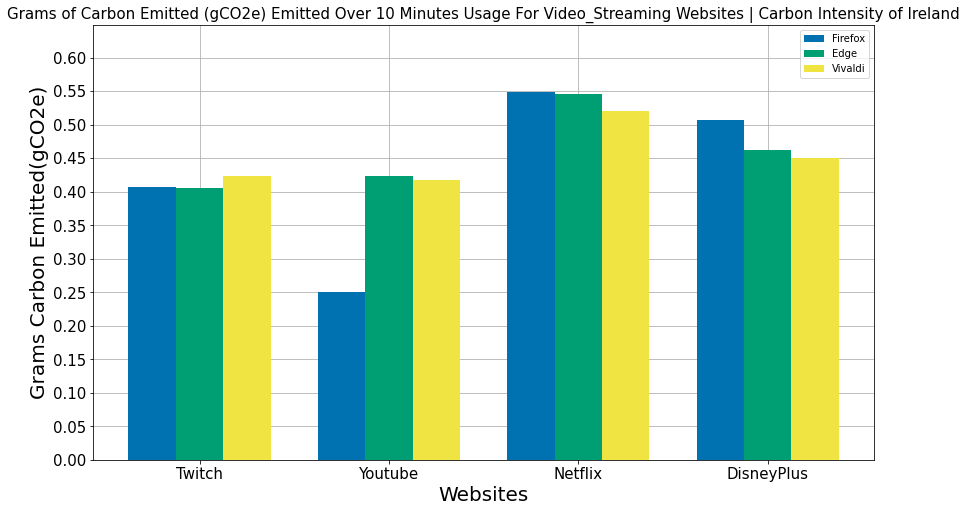

['GoogleNews', 'IrishTimes', 'Independent', 'TheJournal']
Max_Y = 0.280758


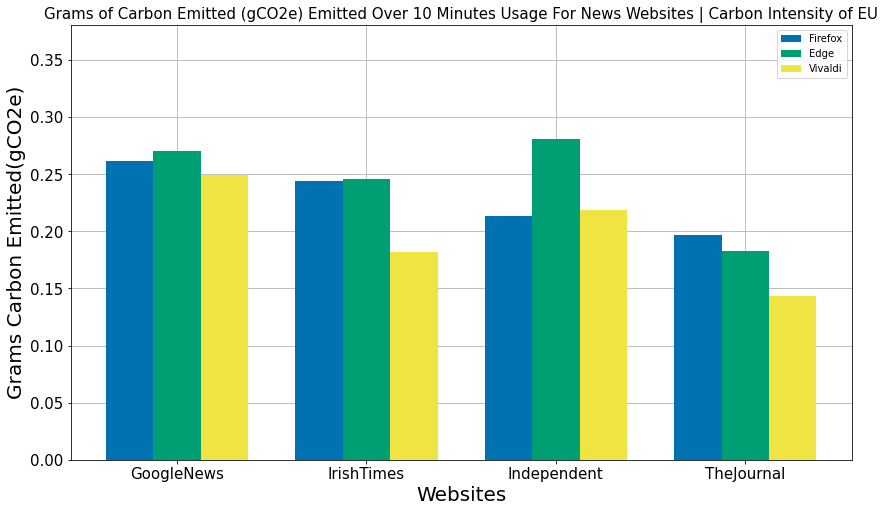

['Asos', 'Etsy', 'Amazon', 'Ikea']
Max_Y = 0.366836


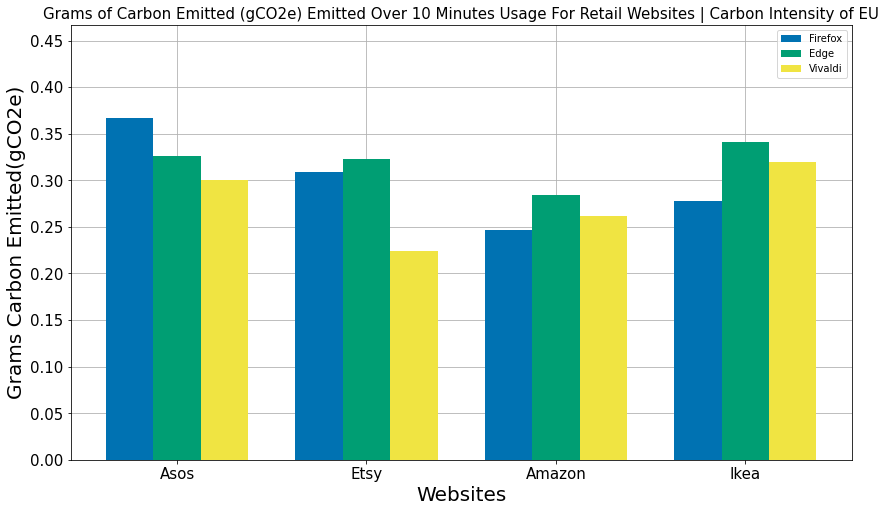

['Instagram', 'Twitter', 'Facebook', 'Reddit']
Max_Y = 0.432605


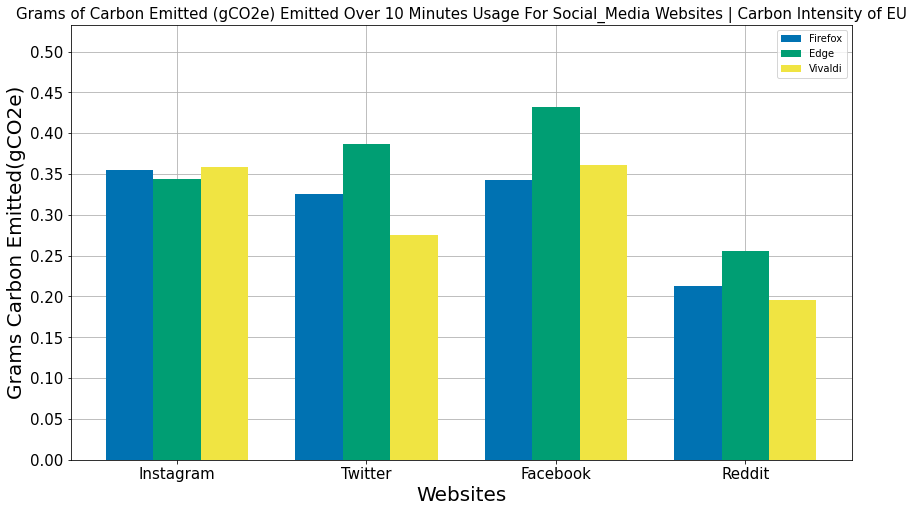

['Twitch', 'Youtube', 'Netflix', 'DisneyPlus']
Max_Y = 0.477642


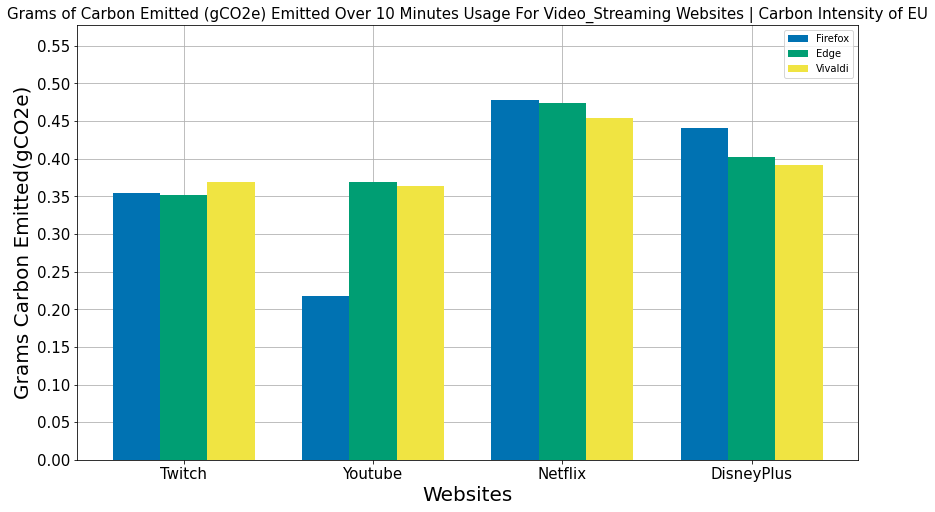

['GoogleNews', 'IrishTimes', 'Independent', 'TheJournal']
Max_Y = 0.425732


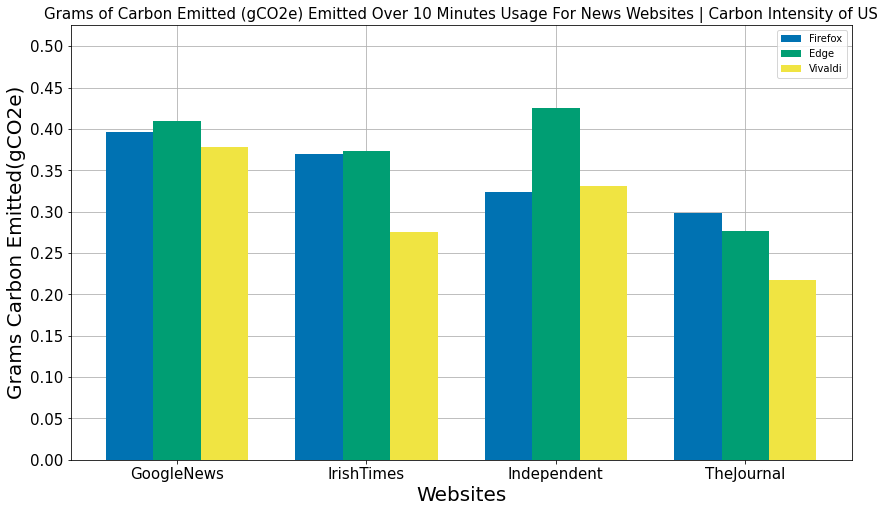

['Asos', 'Etsy', 'Amazon', 'Ikea']
Max_Y = 0.556257


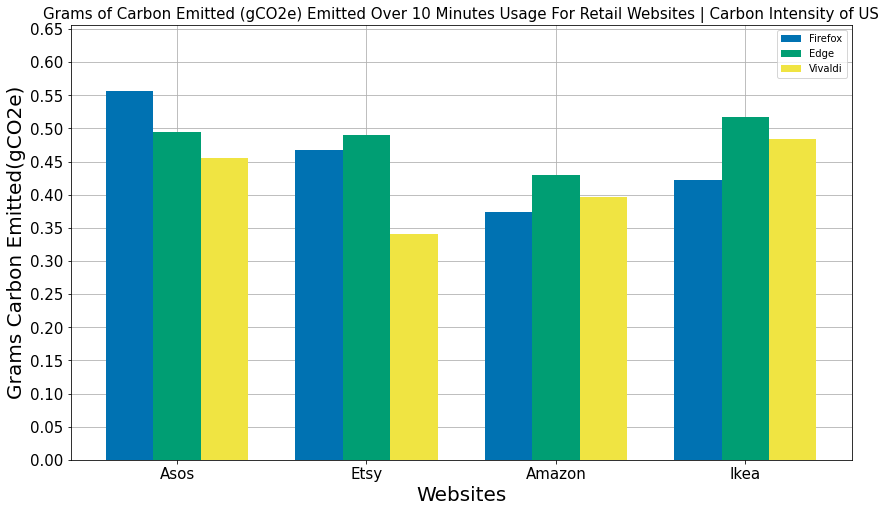

['Instagram', 'Twitter', 'Facebook', 'Reddit']
Max_Y = 0.655987


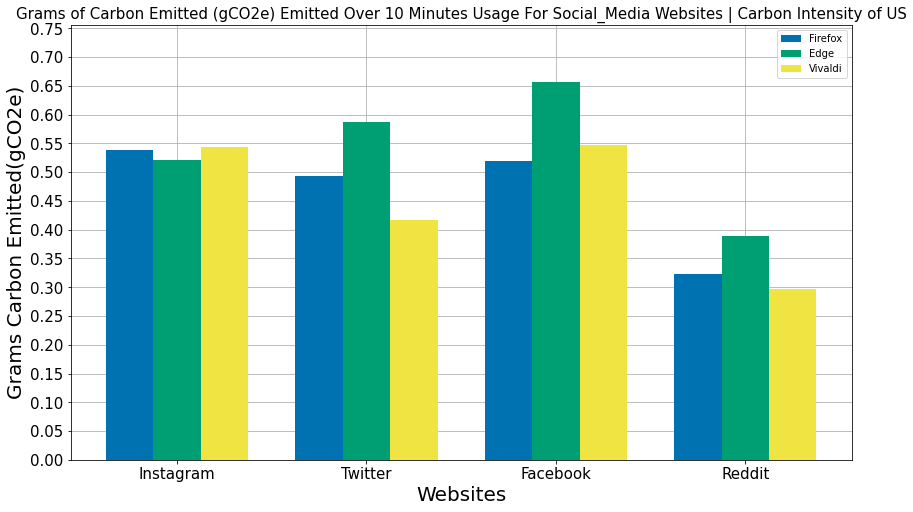

['Twitch', 'Youtube', 'Netflix', 'DisneyPlus']
Max_Y = 0.724279


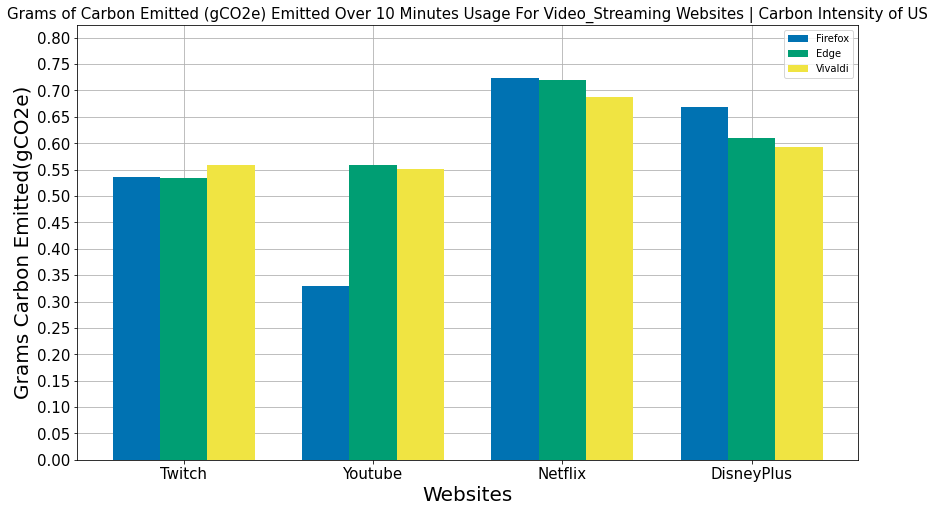

In [119]:
for ci in carbon_intensities:
    for category in categories[:-1]:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.grid(zorder=0)
        data_dict = per_website_wh[category]
        x_labels = list(set([t[0] for t in data_dict[browser] for browser in browsers])) ## dirty but easy
        print(x_labels)
        x = np.arange(len(x_labels))  # the label locations
        width = 0.25  # the width of the bars
        bar_locations = [x, x+width, x+width*2]
        y_data = []

        for i in range(len(browsers)):
            d = [t[1] for t in data_dict[browsers[i]]]
            y_data.append([kwh_to_grams_carbon(val/1000, carbon_intensities[ci]) for val in d])

        plt.xticks(x+width, x_labels, fontsize=15)
        ax.set_xticklabels(x_labels)

        max_y = max([max(y) for y in y_data])
        print(f'Max_Y = {max_y}')
        plt.yticks([y for y in np.arange(0, max_y+0.1, 0.05)],fontsize=15)
        plt.ylim(0.0, max_y+0.1)
        bar_one = ax.bar(bar_locations[0], y_data[0], width, label='Firefox', color=colours[0], zorder=3) # firefox
        bar_two = ax.bar(bar_locations[1], y_data[1], width, label='Edge', color=colours[1], zorder=3) # edge
        bar_three = ax.bar(bar_locations[2], y_data[2], width, label='Vivaldi', color=colours[2], zorder=3) # vivaldi
#         fig.tight_layout()
        ax.legend()

        plt.title(f'Grams of Carbon Emitted (gCO2e) Emitted Over 10 Minutes Usage For {category} Websites | Carbon Intensity of {ci}', fontsize=15)
        plt.ylabel('Grams Carbon Emitted(gCO2e)', fontsize=20)
        plt.xlabel('Websites', fontsize=20)
        plt.savefig(f'plots/papillon/website_carbon_emissions_{category}_{ci}.jpg')
        plt.show()

In [100]:
mean_category_values = []
for category in categories[:-1]:
    mean_category_power = 0
    for browser in browsers:
        data = per_browser_data[category][browser]
        for website in per_browser_data[category][browser]:
            mean_category_power += website[1]
    mean_category_values.append((category, round(mean_category_power/12,4) ) )
print(mean_category_values)

[('News', 4.8865), ('Retail', 6.5072), ('Social_Media', 6.9942), ('Video_Streaming', 8.4816)]


In [101]:
mean_category_power = [t[1] for t in mean_category_values]
print(mean_category_power)

mean_category_energy = [round(c[1] * period,4) for c in mean_category_values]
print(mean_category_energy)

mean_category_carbon = [kwh_to_grams_carbon(wh/1000, carbon_intensities['Ireland']) for wh in mean_category_energy]
print(mean_category_carbon)

[4.8865, 6.5072, 6.9942, 8.4816]
[0.8144, 1.0845, 1.1657, 1.4136]
[0.25735, 0.342702, 0.368361, 0.446698]


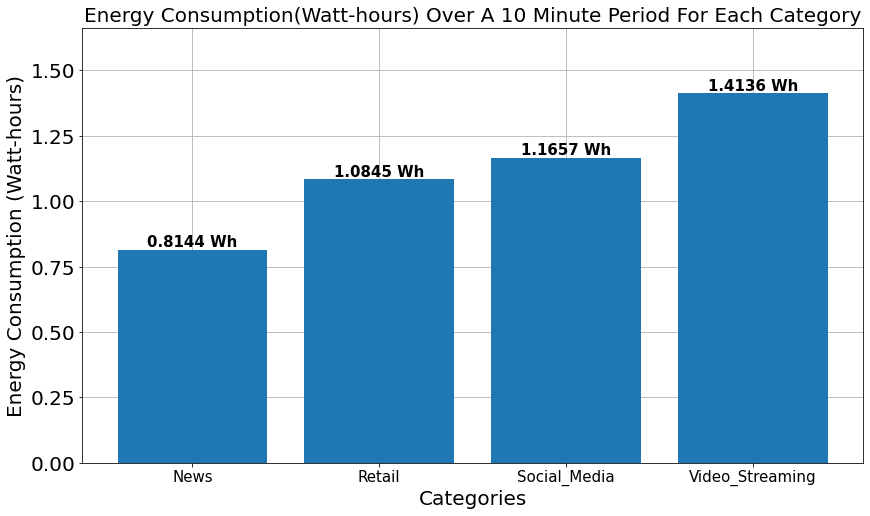

In [102]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.title('Energy Consumption(Watt-hours) Over A 10 Minute Period For Each Category', fontsize=20)
plt.ylabel('Energy Consumption (Watt-hours)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(mean_category_energy)+0.5, 0.25)], fontsize=20)
plt.ylim(0, max(mean_category_energy)+ 0.25)
plt.xlabel('Categories', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(categories[:-1], mean_category_energy, align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f Wh' % round(height,4), fontsize=15, ha='center', va='bottom',weight='bold')

plt.savefig('plots/papillon/energy_per_category.jpg')
plt.show()

In [103]:
cost_values = [convert_wh_to_cost(mean_value) for mean_value in mean_category_energy]

print(cost_values)
rows = []
for i in range(len(categories[:-1])):
    browser_name = categories[i]
    cost_per_ten_minutes = cost_values[i]
    cost_per_minute = cost_per_ten_minutes / 10
    cost_per_hour = cost_per_ten_minutes * 6
    cost_per_day = cost_per_hour * 24 
    rows.append({
        'Browser' : browser_name,
        'Cost Per Minute' : cost_per_minute,
        'Cost Per 10 Minutes' : cost_per_ten_minutes,
        'Cost Per Hour' : cost_per_hour,
        'Cost Per Day' : cost_per_day
    })
cost_df = pd.DataFrame(rows)

[0.00016, 0.00022, 0.00023, 0.00028]


In [104]:
display(cost_df.style.set_caption('Cost of Running an Idle Browser in Euro Cent'))
dfi.export(cost_df.style.set_caption('Cost of Running an Idle Browser in Euro Cent'),"plots/papillon/cost_table.jpg")

,Browser,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,News,0.000016,0.000160,0.000960,0.023040
1,Retail,0.000022,0.000220,0.001320,0.031680
2,Social_Media,0.000023,0.000230,0.001380,0.033120
3,Video_Streaming,0.000028,0.000280,0.001680,0.040320


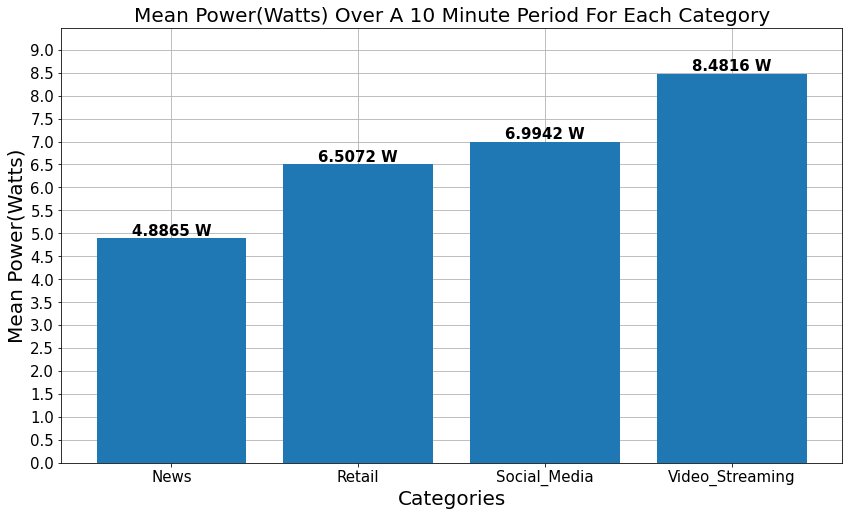

In [105]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.title('Mean Power(Watts) Over A 10 Minute Period For Each Category', fontsize=20)
plt.ylabel('Mean Power(Watts)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(mean_category_power)+2, 0.5)], fontsize=15)
plt.ylim(0, max(mean_category_power)+1)
plt.xlabel('Categories', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(categories[:-1], mean_category_power, align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f W' % round(height,4), fontsize=15, ha='center', va='bottom',weight='bold')

plt.savefig('plots/papillon/power_per_category.jpg')
plt.show()

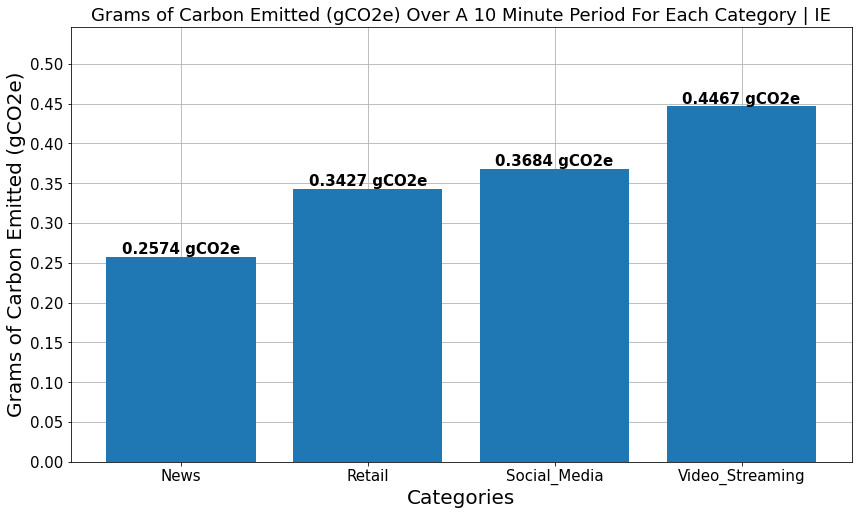

In [106]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.title('Grams of Carbon Emitted (gCO2e) Over A 10 Minute Period For Each Category | IE', fontsize=18)
plt.ylabel('Grams of Carbon Emitted (gCO2e)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(mean_category_carbon)+0.1, 0.05)], fontsize=15)
plt.ylim(0, max(mean_category_carbon)+0.1)
plt.xlabel('Categories', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(categories[:-1], mean_category_carbon, align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f gCO2e' % round(height,4), fontsize=15, ha='center', va='bottom',weight='bold')

plt.savefig('plots/papillon/mean_carbon_per_category.jpg')
plt.show()

In [107]:
grams_per_region = {}
for ci in carbon_intensities:
    ci_value = carbon_intensities[ci]
    grams = [kwh_to_grams_carbon(value/1000, ci_value) for value in mean_category_energy]
    grams_per_region[ci] = grams
print(grams_per_region)

{'Ireland': [0.25735, 0.342702, 0.368361, 0.446698], 'EU': [0.22396, 0.298238, 0.320568, 0.38874], 'US': [0.339605, 0.452236, 0.486097, 0.589471]}


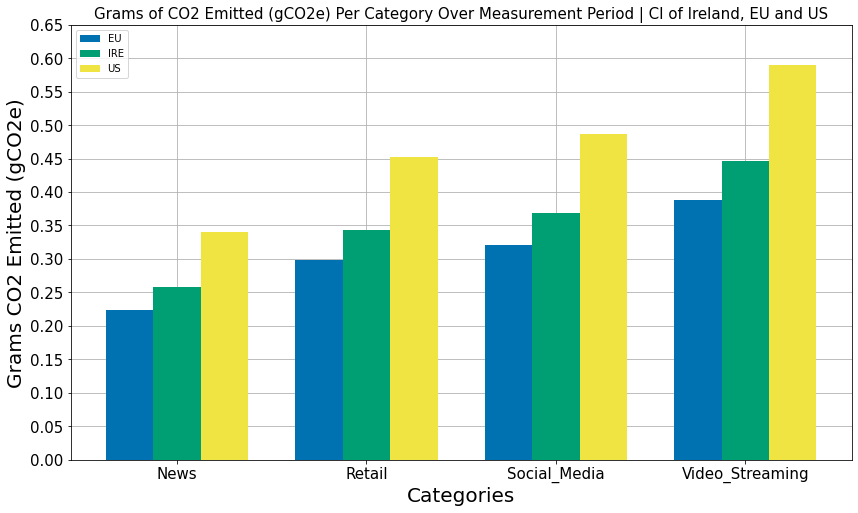

In [108]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.grid(zorder=0)
x = np.arange(len(categories[:-1]))  # the label locations
width = 0.25  # the width of the bars
rects2 = ax.bar(x , grams_per_region['EU'], width, label='EU', color=colours[0], zorder=3)
rects1 = ax.bar(x + width, grams_per_region['Ireland'], width, label='IRE', color=colours[1], zorder=3)
rects3 = ax.bar(x + width*2, grams_per_region['US'], width, label='US', color=colours[2] , zorder=3)

plt.title('Grams of CO2 Emitted (gCO2e) Per Category Over Measurement Period | CI of Ireland, EU and US', fontsize=15)
plt.xticks(x+width, categories[:-1], fontsize=15)
max_y = max(max([grams_per_region[region] for region in grams_per_region]))
plt.yticks([i for i in np.arange(0, max_y + 0.1, 0.05)], fontsize=15)
ax.set_xticklabels(categories[:-1])
ax.legend()

plt.ylabel('Grams CO2 Emitted (gCO2e)',fontsize=20)
plt.xlabel('Categories', fontsize=20)

# fig.tight_layout()
plt.savefig('plots/papillon/grams_per_category_per_region.jpg')
plt.show()

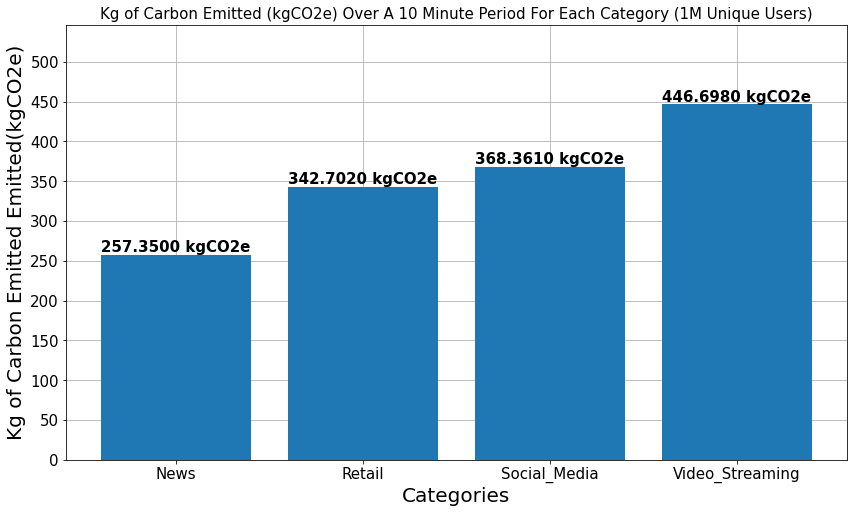

In [109]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.title('Kg of Carbon Emitted (kgCO2e) Over A 10 Minute Period For Each Category (1M Unique Users)', fontsize=15)
plt.ylabel('Kg of Carbon Emitted Emitted(kgCO2e)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(mean_category_carbon)*1e+6/1000 + 100, 50)], fontsize=15)
plt.ylim(0, max(mean_category_carbon)*1e+6/1000 + 100)
plt.xlabel('Categories', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(categories[:-1], [(carbon * 1e+6) / 1000 for carbon in mean_category_carbon] , align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f kgCO2e' % round(height,4), ha='center', fontsize=15, va='bottom',weight='bold')

plt.savefig('plots/papillon/mean_carbon_per_category_1m.jpg')
plt.show()

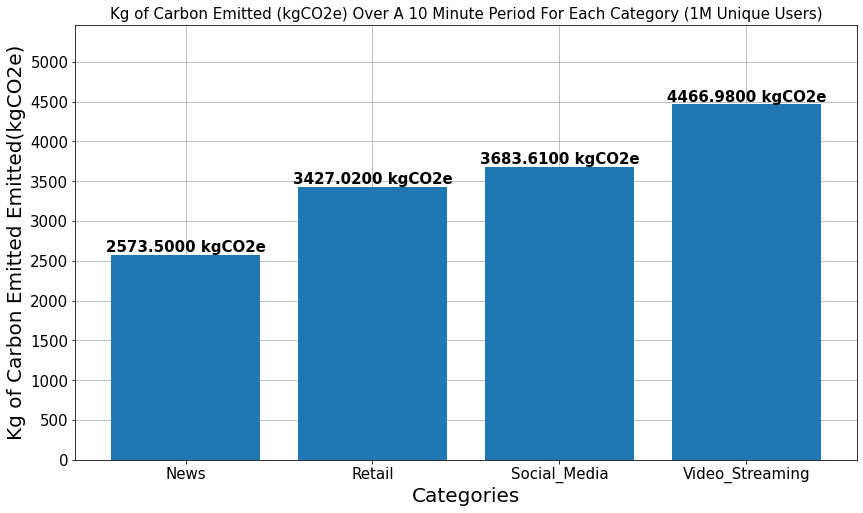

In [112]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.title('Kg of Carbon Emitted (kgCO2e) Over A 10 Minute Period For Each Category (1M Unique Users)', fontsize=15)
plt.ylabel('Kg of Carbon Emitted Emitted(kgCO2e)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(mean_category_carbon)*10e+6/1000 + 1000, 500)], fontsize=15)
plt.ylim(0, max(mean_category_carbon)*10e+6/1000 + 1000)
plt.xlabel('Categories', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(categories[:-1], [(carbon * 10e+6) / 1000 for carbon in mean_category_carbon] , align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f kgCO2e' % round(height,4), ha='center', fontsize=15, va='bottom',weight='bold')

plt.savefig('plots/papillon/mean_carbon_per_category_1m.jpg')
plt.show()

In [113]:
print(mean_category_power)
mean_baseline_power = 3.1549 ## mean of the three baseline values for  the browsers

mean_baseline_energy = mean_baseline_power * period
print(mean_baseline_energy)

category_baseline_difference = [round(power - mean_baseline_power,4) for power in mean_category_power]
print(category_baseline_difference)

energy_baseline_difference = [round(power - mean_baseline_energy,4) for power in mean_category_energy]
print(energy_baseline_difference)

[4.8865, 6.5072, 6.9942, 8.4816]
0.5258166666666666
[1.7316, 3.3523, 3.8393, 5.3267]
[0.2886, 0.5587, 0.6399, 0.8878]


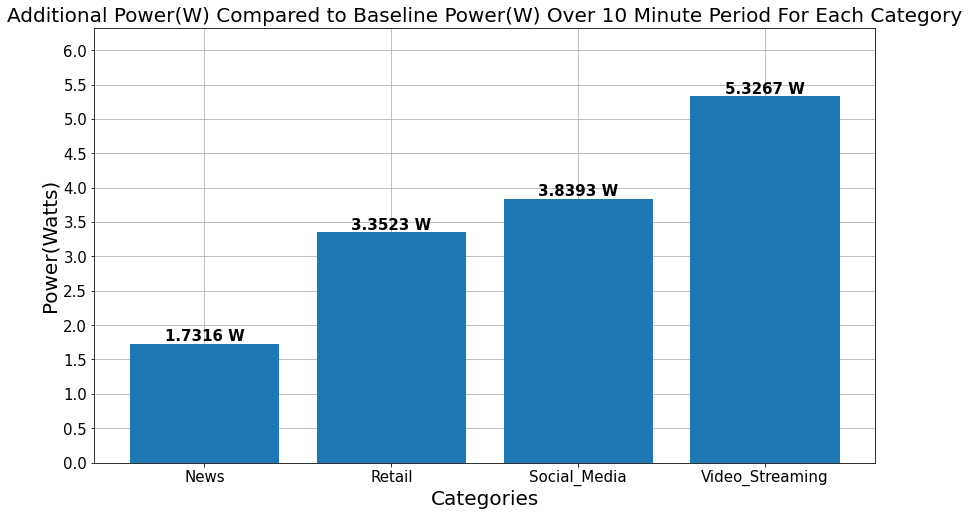

In [114]:
ig, ax = plt.subplots(figsize=(14, 8))
plt.title('Additional Power(W) Compared to Baseline Power(W) Over 10 Minute Period For Each Category', fontsize=20)
plt.ylabel('Power(Watts)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(category_baseline_difference)+2, 0.5)], fontsize=15)
plt.ylim(0, max(category_baseline_difference)+1)
plt.xlabel('Categories', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(categories[:-1], category_baseline_difference, align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f W' % round(height,4), fontsize=15, ha='center', va='bottom',weight='bold')

plt.savefig('plots/papillon/difference_from_baseline.jpg')
plt.show()

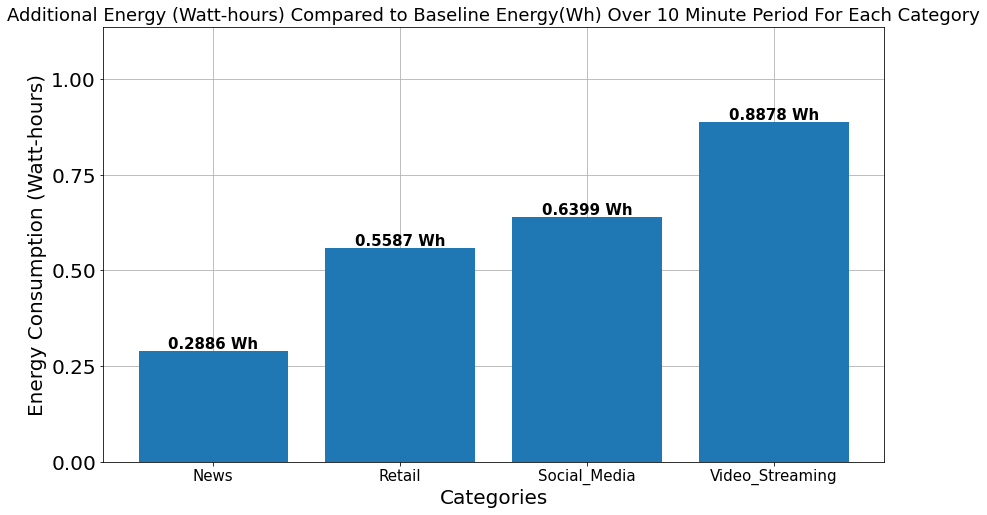

In [115]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.title('Additional Energy (Watt-hours) Compared to Baseline Energy(Wh) Over 10 Minute Period For Each Category', fontsize=18)
plt.ylabel('Energy Consumption (Watt-hours)', fontsize=20)
plt.yticks([i for i in np.arange(0.0, max(energy_baseline_difference)+0.5, 0.25)], fontsize=20)
plt.ylim(0, max(energy_baseline_difference)+ 0.25)
plt.xlabel('Categories', fontsize=20)
plt.xticks(fontsize=15)
ax.grid(zorder=0)
bars = plt.bar(categories[:-1], energy_baseline_difference, align='center',zorder=3)
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f Wh' % round(height,4), fontsize=15, ha='center', va='bottom',weight='bold')

plt.savefig('plots/papillon/energy_difference.jpg')
plt.show()

In [116]:
def cost_table(category, browser, website_name, total_power_consumption):  
    cost_per_ten_minutes = convert_wh_to_cost(total_power_consumption)
    cost_per_minute = cost_per_ten_minutes / 10
    cost_per_hour = cost_per_ten_minutes * 6
    cost_per_day = cost_per_hour * 24 
    return {
        'Website' : website_name,
        'Cost Per Minute' : cost_per_minute,
        'Cost Per 10 Minutes' : cost_per_ten_minutes,
        'Cost Per Hour' : cost_per_hour,
        'Cost Per Day' : cost_per_day
    }

def carbon_table(category, browser, website_name, total_power_consumption, ci_key='Ireland'):
    ce_per_ten_minutes = kwh_to_grams_carbon(total_power_consumption/1000, carbon_intensities[ci_key])
    return {
        'Website' : website_name,
        'gCO2e Per Minute':ce_per_ten_minutes/10,
        'gCO2e Per 10 Minutes': ce_per_ten_minutes,
        'gCO2e Per Hour':ce_per_ten_minutes * 6,
        'KgCO2e Per 10 Minutes/10K Unique Vistors' : round((ce_per_ten_minutes * 10000) / 1000),
        'KgCO2e Per 10 Minutes/100K Unique Vistors' : round((ce_per_ten_minutes * 100000) / 1000),
        'KgCO2e Per 10 Minutes/1M Unique Vistors' : round((ce_per_ten_minutes * 1e+6) / 1000)        
    }


In [117]:
# print(per_browser_data['News']['Edge'])
for category in per_browser_data:
    print(category)
    for browser in per_browser_data[category]:
        for ci in carbon_intensities:
            title = f'Grams of CO2 Emitted - {browser} - {category} - Region:{ci}'
            rows = []
            for website in per_browser_data[category][browser]:
                rows.append(carbon_table(category, browser, website[0], website[1], ci))
            df = pd.DataFrame(rows)
            titled_df = df.style.set_properties(**{'text-align': 'center'}).set_caption(title)
            display(titled_df)
            dfi.export(titled_df, f'plots/papillon/carbon_emissions_table_{category}_{browser}_{ci}.jpg')

News


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.180237,1.802372,10.814232,18,180,1802
1,Independent,0.168278,1.682776,10.096656,17,168,1683
2,IrishTimes,0.146997,1.469969,8.819814,15,147,1470
3,TheJournal,0.135412,1.354117,8.124702,14,135,1354


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.156852,1.568520,9.411120,16,157,1569
1,Independent,0.146444,1.464441,8.786646,15,146,1464
2,IrishTimes,0.127924,1.279245,7.675470,13,128,1279
3,TheJournal,0.117843,1.178425,7.070550,12,118,1178


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.237845,2.378447,14.270682,24,238,2378
1,Independent,0.222062,2.220625,13.323750,22,222,2221
2,IrishTimes,0.193980,1.939801,11.638806,19,194,1940
3,TheJournal,0.178692,1.786920,10.721520,18,179,1787


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.186185,1.861853,11.171118,19,186,1862
1,Independent,0.169700,1.696996,10.181976,17,170,1697
2,IrishTimes,0.193570,1.935696,11.614176,19,194,1936
3,TheJournal,0.125865,1.258653,7.551918,13,126,1259


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.162028,1.620284,9.721704,16,162,1620
1,Independent,0.147682,1.476816,8.860896,15,148,1477
2,IrishTimes,0.168455,1.684546,10.107276,17,168,1685
3,TheJournal,0.109535,1.095347,6.572082,11,110,1095


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.245694,2.456939,14.741634,25,246,2457
1,Independent,0.223939,2.239390,13.436340,22,224,2239
2,IrishTimes,0.255438,2.554384,15.326304,26,255,2554
3,TheJournal,0.166094,1.660944,9.965664,17,166,1661


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.172052,1.720519,10.323114,17,172,1721
1,Independent,0.125150,1.251502,7.509012,13,125,1252
2,IrishTimes,0.150568,1.505683,9.034098,15,151,1506
3,TheJournal,0.098949,0.989494,5.936964,10,99,989


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.149729,1.497287,8.983722,15,150,1497
1,Independent,0.108912,1.089124,6.534744,11,109,1089
2,IrishTimes,0.131033,1.310326,7.861956,13,131,1310
3,TheJournal,0.086111,0.861110,5.166660,9,86,861


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,GoogleNews,0.227043,2.270432,13.622592,23,227,2270
1,Independent,0.165151,1.651508,9.909048,17,165,1652
2,IrishTimes,0.198693,1.986930,11.921580,20,199,1987
3,TheJournal,0.130576,1.305756,7.834536,13,131,1306


Retail


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.252917,2.529172,15.175032,25,253,2529
1,Asos,0.212832,2.128323,12.769938,21,213,2128
2,Etsy,0.170016,1.700162,10.200972,17,170,1700
3,Ikea,0.191886,1.918863,11.513178,19,192,1919


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.220102,2.201020,13.206120,22,220,2201
1,Asos,0.185218,1.852180,11.113080,19,185,1852
2,Etsy,0.147957,1.479571,8.877426,15,148,1480
3,Ikea,0.166990,1.669896,10.019376,17,167,1670


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.333755,3.337547,20.025282,33,334,3338
1,Asos,0.280858,2.808578,16.851468,28,281,2809
2,Etsy,0.224357,2.243568,13.461408,22,224,2244
3,Ikea,0.253217,2.532170,15.193020,25,253,2532


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.224693,2.246931,13.481586,22,225,2247
1,Asos,0.222568,2.225676,13.354056,22,223,2226
2,Etsy,0.195698,1.956982,11.741892,20,196,1957
3,Ikea,0.235143,2.351429,14.108574,24,235,2351


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.195540,1.955398,11.732388,20,196,1955
1,Asos,0.193690,1.936902,11.621412,19,194,1937
2,Etsy,0.170307,1.703070,10.218420,17,170,1703
3,Ikea,0.204634,2.046338,12.278028,20,205,2046


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.296509,2.965095,17.790570,30,297,2965
1,Asos,0.293705,2.937048,17.622288,29,294,2937
2,Etsy,0.258247,2.582473,15.494838,26,258,2582
3,Ikea,0.310299,3.102993,18.617958,31,310,3103


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.206752,2.067515,12.405090,21,207,2068
1,Asos,0.154741,1.547411,9.284466,15,155,1547
2,Etsy,0.180128,1.801282,10.807692,18,180,1801
3,Ikea,0.220163,2.201629,13.209774,22,220,2202


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.179926,1.799262,10.795572,18,180,1799
1,Asos,0.134664,1.346639,8.079834,13,135,1347
2,Etsy,0.156757,1.567572,9.405432,16,157,1568
3,Ikea,0.191597,1.915974,11.495844,19,192,1916


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Amazon,0.272834,2.728335,16.370010,27,273,2728
1,Asos,0.204200,2.041995,12.251970,20,204,2042
2,Etsy,0.237701,2.377008,14.262048,24,238,2377
3,Ikea,0.290531,2.905314,17.431884,29,291,2905


Social_Media


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.244620,2.446203,14.677218,24,245,2446
1,Instagram,0.224687,2.246867,13.481202,22,225,2247
2,Reddit,0.235995,2.359951,14.159706,24,236,2360
3,Twitter,0.146862,1.468619,8.811714,15,147,1469


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.212882,2.128816,12.772896,21,213,2129
1,Instagram,0.195534,1.955344,11.732064,20,196,1955
2,Reddit,0.205376,2.053755,12.322530,21,205,2054
3,Twitter,0.127807,1.278071,7.668426,13,128,1278


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.322806,3.228060,19.368360,32,323,3228
1,Instagram,0.296501,2.965012,17.790072,30,297,2965
2,Reddit,0.311424,3.114239,18.685434,31,311,3114
3,Twitter,0.193802,1.938020,11.628120,19,194,1938


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.236966,2.369659,14.217954,24,237,2370
1,Instagram,0.266995,2.669950,16.019700,27,267,2670
2,Reddit,0.298262,2.982617,17.895702,30,298,2983
3,Twitter,0.176602,1.766017,10.596102,18,177,1766


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.206220,2.062203,12.373218,21,206,2062
1,Instagram,0.232353,2.323533,13.941198,23,232,2324
2,Reddit,0.259563,2.595632,15.573792,26,260,2596
3,Twitter,0.153688,1.536881,9.221286,15,154,1537


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.312705,3.127050,18.762300,31,313,3127
1,Instagram,0.352332,3.523321,21.139926,35,352,3523
2,Reddit,0.393592,3.935921,23.615526,39,394,3936
3,Twitter,0.233047,2.330471,13.982826,23,233,2330


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.247450,2.474495,14.846970,25,247,2474
1,Instagram,0.189483,1.894828,11.368968,19,189,1895
2,Reddit,0.249143,2.491426,14.948556,25,249,2491
3,Twitter,0.135119,1.351191,8.107146,14,135,1351


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.215344,2.153437,12.920622,22,215,2153
1,Instagram,0.164898,1.648980,9.893880,16,165,1649
2,Reddit,0.216817,2.168172,13.009032,22,217,2168
3,Twitter,0.117588,1.175878,7.055268,12,118,1176


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,Facebook,0.326539,3.265394,19.592364,33,327,3265
1,Instagram,0.250045,2.500453,15.002718,25,250,2500
2,Reddit,0.328774,3.287736,19.726416,33,329,3288
3,Twitter,0.178306,1.783059,10.698354,18,178,1783


Video_Streaming


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.244041,2.440411,14.642466,24,244,2440
1,Netflix,0.149887,1.498873,8.993238,15,150,1499
2,Twitch,0.329313,3.293131,19.758786,33,329,3293
3,Youtube,0.304247,3.042470,18.254820,30,304,3042


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.212378,2.123776,12.742656,21,212,2124
1,Netflix,0.130440,1.304399,7.826394,13,130,1304
2,Twitch,0.286586,2.865857,17.195142,29,287,2866
3,Youtube,0.264772,2.647719,15.886314,26,265,2648


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.322042,3.220416,19.322496,32,322,3220
1,Netflix,0.197794,1.977944,11.867664,20,198,1978
2,Twitch,0.434568,4.345682,26.074092,43,435,4346
3,Youtube,0.401490,4.014905,24.089430,40,401,4015


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.242931,2.429313,14.575878,24,243,2429
1,Netflix,0.253992,2.539920,15.239520,25,254,2540
2,Twitch,0.327118,3.271185,19.627110,33,327,3271
3,Youtube,0.277144,2.771440,16.628640,28,277,2771


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.211412,2.114118,12.684708,21,211,2114
1,Netflix,0.221037,2.210373,13.262238,22,221,2210
2,Twitch,0.284676,2.846759,17.080554,28,285,2847
3,Youtube,0.241185,2.411854,14.471124,24,241,2412


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.320577,3.205771,19.234626,32,321,3206
1,Netflix,0.335173,3.351729,20.110374,34,335,3352
2,Twitch,0.431672,4.316721,25.900326,43,432,4317
3,Youtube,0.365725,3.657248,21.943488,37,366,3657


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.254330,2.543301,15.259806,25,254,2543
1,Netflix,0.250583,2.505829,15.034974,25,251,2506
2,Twitch,0.312635,3.126352,18.758112,31,313,3126
3,Youtube,0.269983,2.699831,16.198986,27,270,2700


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.221332,2.213316,13.279896,22,221,2213
1,Netflix,0.218071,2.180706,13.084236,22,218,2181
2,Twitch,0.272072,2.720718,16.324308,27,272,2721
3,Youtube,0.234954,2.349537,14.097222,23,235,2350


,Website,gCO2e Per Minute,gCO2e Per 10 Minutes,gCO2e Per Hour,KgCO2e Per 10 Minutes/10K Unique Vistors,KgCO2e Per 10 Minutes/100K Unique Vistors,KgCO2e Per 10 Minutes/1M Unique Vistors
0,DisneyPlus,0.335619,3.356191,20.137146,34,336,3356
1,Netflix,0.330674,3.306743,19.840458,33,331,3307
2,Twitch,0.412560,4.125598,24.753588,41,413,4126
3,Youtube,0.356275,3.562752,21.376512,36,356,3563


In [118]:
# print(per_browser_data['News']['Edge'])
for category in per_browser_data:
    print(category)
    for browser in per_browser_data[category]:
            title = f'{browser} - {category} - Cost in Euro Cent'
            rows = []
            for website in per_browser_data[category][browser]:
                rows.append(cost_table(category, browser, website[0], website[1]))
            df = pd.DataFrame(rows)
            titled_df = df.style.set_properties(**{'text-align': 'center'}).set_caption(title)
            display(titled_df)
            dfi.export(titled_df, f'plots/papillon/cost_table_{category}_{browser}.jpg')

News


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,GoogleNews,0.000114,0.001140,0.006840,0.164160
1,Independent,0.000107,0.001070,0.006420,0.154080
2,IrishTimes,0.000093,0.000930,0.005580,0.133920
3,TheJournal,0.000086,0.000860,0.005160,0.123840


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,GoogleNews,0.000118,0.001180,0.007080,0.169920
1,Independent,0.000107,0.001070,0.006420,0.154080
2,IrishTimes,0.000123,0.001230,0.007380,0.177120
3,TheJournal,0.000080,0.000800,0.004800,0.115200


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,GoogleNews,0.000109,0.001090,0.006540,0.156960
1,Independent,0.000079,0.000790,0.004740,0.113760
2,IrishTimes,0.000095,0.000950,0.005700,0.136800
3,TheJournal,0.000063,0.000630,0.003780,0.090720


Retail


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,Amazon,0.000160,0.001600,0.009600,0.230400
1,Asos,0.000135,0.001350,0.008100,0.194400
2,Etsy,0.000108,0.001080,0.006480,0.155520
3,Ikea,0.000121,0.001210,0.007260,0.174240


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,Amazon,0.000142,0.001420,0.008520,0.204480
1,Asos,0.000141,0.001410,0.008460,0.203040
2,Etsy,0.000124,0.001240,0.007440,0.178560
3,Ikea,0.000149,0.001490,0.008940,0.214560


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,Amazon,0.000131,0.001310,0.007860,0.188640
1,Asos,0.000098,0.000980,0.005880,0.141120
2,Etsy,0.000114,0.001140,0.006840,0.164160
3,Ikea,0.000139,0.001390,0.008340,0.200160


Social_Media


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,Facebook,0.000155,0.001550,0.009300,0.223200
1,Instagram,0.000142,0.001420,0.008520,0.204480
2,Reddit,0.000149,0.001490,0.008940,0.214560
3,Twitter,0.000093,0.000930,0.005580,0.133920


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,Facebook,0.000150,0.001500,0.009000,0.216000
1,Instagram,0.000169,0.001690,0.010140,0.243360
2,Reddit,0.000189,0.001890,0.011340,0.272160
3,Twitter,0.000112,0.001120,0.006720,0.161280


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,Facebook,0.000157,0.001570,0.009420,0.226080
1,Instagram,0.000120,0.001200,0.007200,0.172800
2,Reddit,0.000158,0.001580,0.009480,0.227520
3,Twitter,0.000086,0.000860,0.005160,0.123840


Video_Streaming


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,DisneyPlus,0.000154,0.001540,0.009240,0.221760
1,Netflix,0.000095,0.000950,0.005700,0.136800
2,Twitch,0.000208,0.002080,0.012480,0.299520
3,Youtube,0.000193,0.001930,0.011580,0.277920


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,DisneyPlus,0.000154,0.001540,0.009240,0.221760
1,Netflix,0.000161,0.001610,0.009660,0.231840
2,Twitch,0.000207,0.002070,0.012420,0.298080
3,Youtube,0.000175,0.001750,0.010500,0.252000


,Website,Cost Per Minute,Cost Per 10 Minutes,Cost Per Hour,Cost Per Day
0,DisneyPlus,0.000161,0.001610,0.009660,0.231840
1,Netflix,0.000159,0.001590,0.009540,0.228960
2,Twitch,0.000198,0.001980,0.011880,0.285120
3,Youtube,0.000171,0.001710,0.010260,0.246240


## Some experimenting with the Papillon Stats

The input into the power model in Papillon is the CPU Utilization, Network bytesin and bytesout and the Memory pageins and pageouts, in the previous minute. So it is expected that they are highly correlated with the output Power value. But to just get an idea of how correlated, the graphs in the next few cells were made

In [32]:
## Get all data on power and the stats and put it into a single dataframe
df_list = []
for category in category_data:
    for i in range(len(browsers)):
        data = category_data[category][i].data
        for website in data:
            df_list.append(data[website])
big_df = pd.concat(df_list)

In [33]:
display(big_df)

,Watts,Whrs,Timestamp,Stat1,Stat2,Stat3,All Apps,Tagged App
0,6.101834,1.016972,1.617732e+09,25.604096,5483330.0,11083776.0,12390.0,11340.0
1,8.950610,1.491768,1.617732e+09,73.207076,22633854.0,40341504.0,44150.0,34870.0
2,9.660500,1.610083,1.617733e+09,35.340328,3195900.0,45907968.0,33260.0,28150.0
3,5.574083,0.929014,1.617733e+09,30.079225,3067750.0,9183232.0,20160.0,17860.0
4,3.518533,0.586422,1.617733e+09,3.123885,27249.0,5521408.0,3850.0,3620.0
...,...,...,...,...,...,...,...,...
6,8.858000,1.476333,1.617547e+09,13.527926,31197832.0,31105024.0,21500.0,20070.0
7,8.888915,1.481486,1.617547e+09,14.740726,27263512.0,45285376.0,21420.0,19800.0
8,10.092580,1.682097,1.617547e+09,13.368985,32571652.0,29282304.0,20970.0,19520.0
9,9.290167,1.548361,1.617547e+09,15.412713,28666460.0,27758592.0,21830.0,20440.0


0.6810494682041358
0.6574337673697648
0.9129702358045146


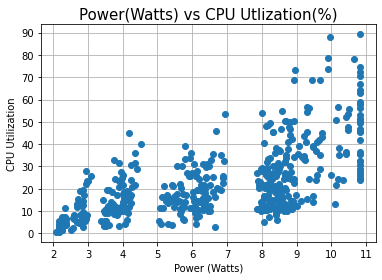

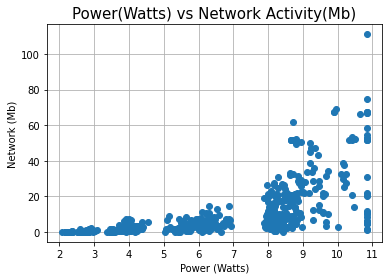

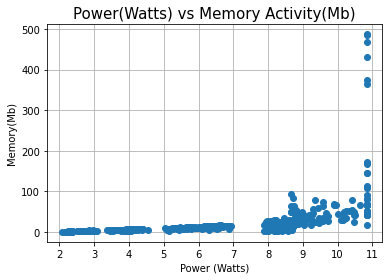

In [65]:
power = big_df['Watts']
cpu = big_df['Stat1']
network = big_df['Stat2']
memory = big_df['Stat3']
print(power.corr(cpu,method='spearman'))
print(power.corr(network))
print(power.corr(memory,method='spearman'))

plt.title('Power(Watts) vs CPU Utlization(%)', fontsize=15)
plt.grid(zorder=0)
plt.xlabel('Power (Watts)')
plt.xticks([x for x in np.arange(0, max(big_df['Watts'])+5,1)])
plt.ylabel('CPU Utilization')
plt.yticks([y for y in range(0, 110, 10)])
plt.scatter(power, cpu, zorder=3)
plt.show()


plt.title('Power(Watts) vs Network Activity(Mb)', fontsize=15)
plt.grid(zorder=0)
plt.xlabel('Power (Watts)')
plt.xticks([x for x in np.arange(0, max(big_df['Watts'])+5,1)])
plt.ylabel('Network (Mb)')
# plt.yticks([y for y in np.arange(0, 1.1, 0.1)])
plt.scatter(power, network.apply(lambda x : x /1e+6), zorder=3)
plt.show()


plt.title('Power(Watts) vs Memory Activity(Mb)', fontsize=15)
plt.grid(zorder=0)
plt.xlabel('Power (Watts)')
plt.xticks([x for x in np.arange(0, max(big_df['Watts'])+5,1)])
plt.ylabel('Memory(Mb)')
plt.scatter(power, memory.apply(lambda x : x /1e+6),zorder=3)
plt.show()